In [1]:
# Block 1: Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm

# Academic color palette (ACL-inspired)
acl_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
              "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]
sns.set(style="whitegrid", palette=acl_colors, font="Times New Roman")
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.dpi'] = 300

# Load data without Sequence column to save memory
cols = ['Tournament', 'Round', 'Group', 'Player 1', 'Player 2', 'Winner', 'Turns']
dtypes = {
    'Tournament': 'int32',
    'Round': 'category',
    'Group': 'category',
    'Player 1': 'category',
    'Player 2': 'category',
    'Winner': 'category',
    'Turns': 'int16'
}

print("Loading data...")
df = pd.read_csv(
    '/kaggle/input/snake-ladder-game-simulation-ai-tournament/tournament_results.csv',
    usecols=cols,
    dtype=dtypes
)
print(f"Data loaded. Shape: {df.shape}")

Loading data...
Data loaded. Shape: (3100000, 7)


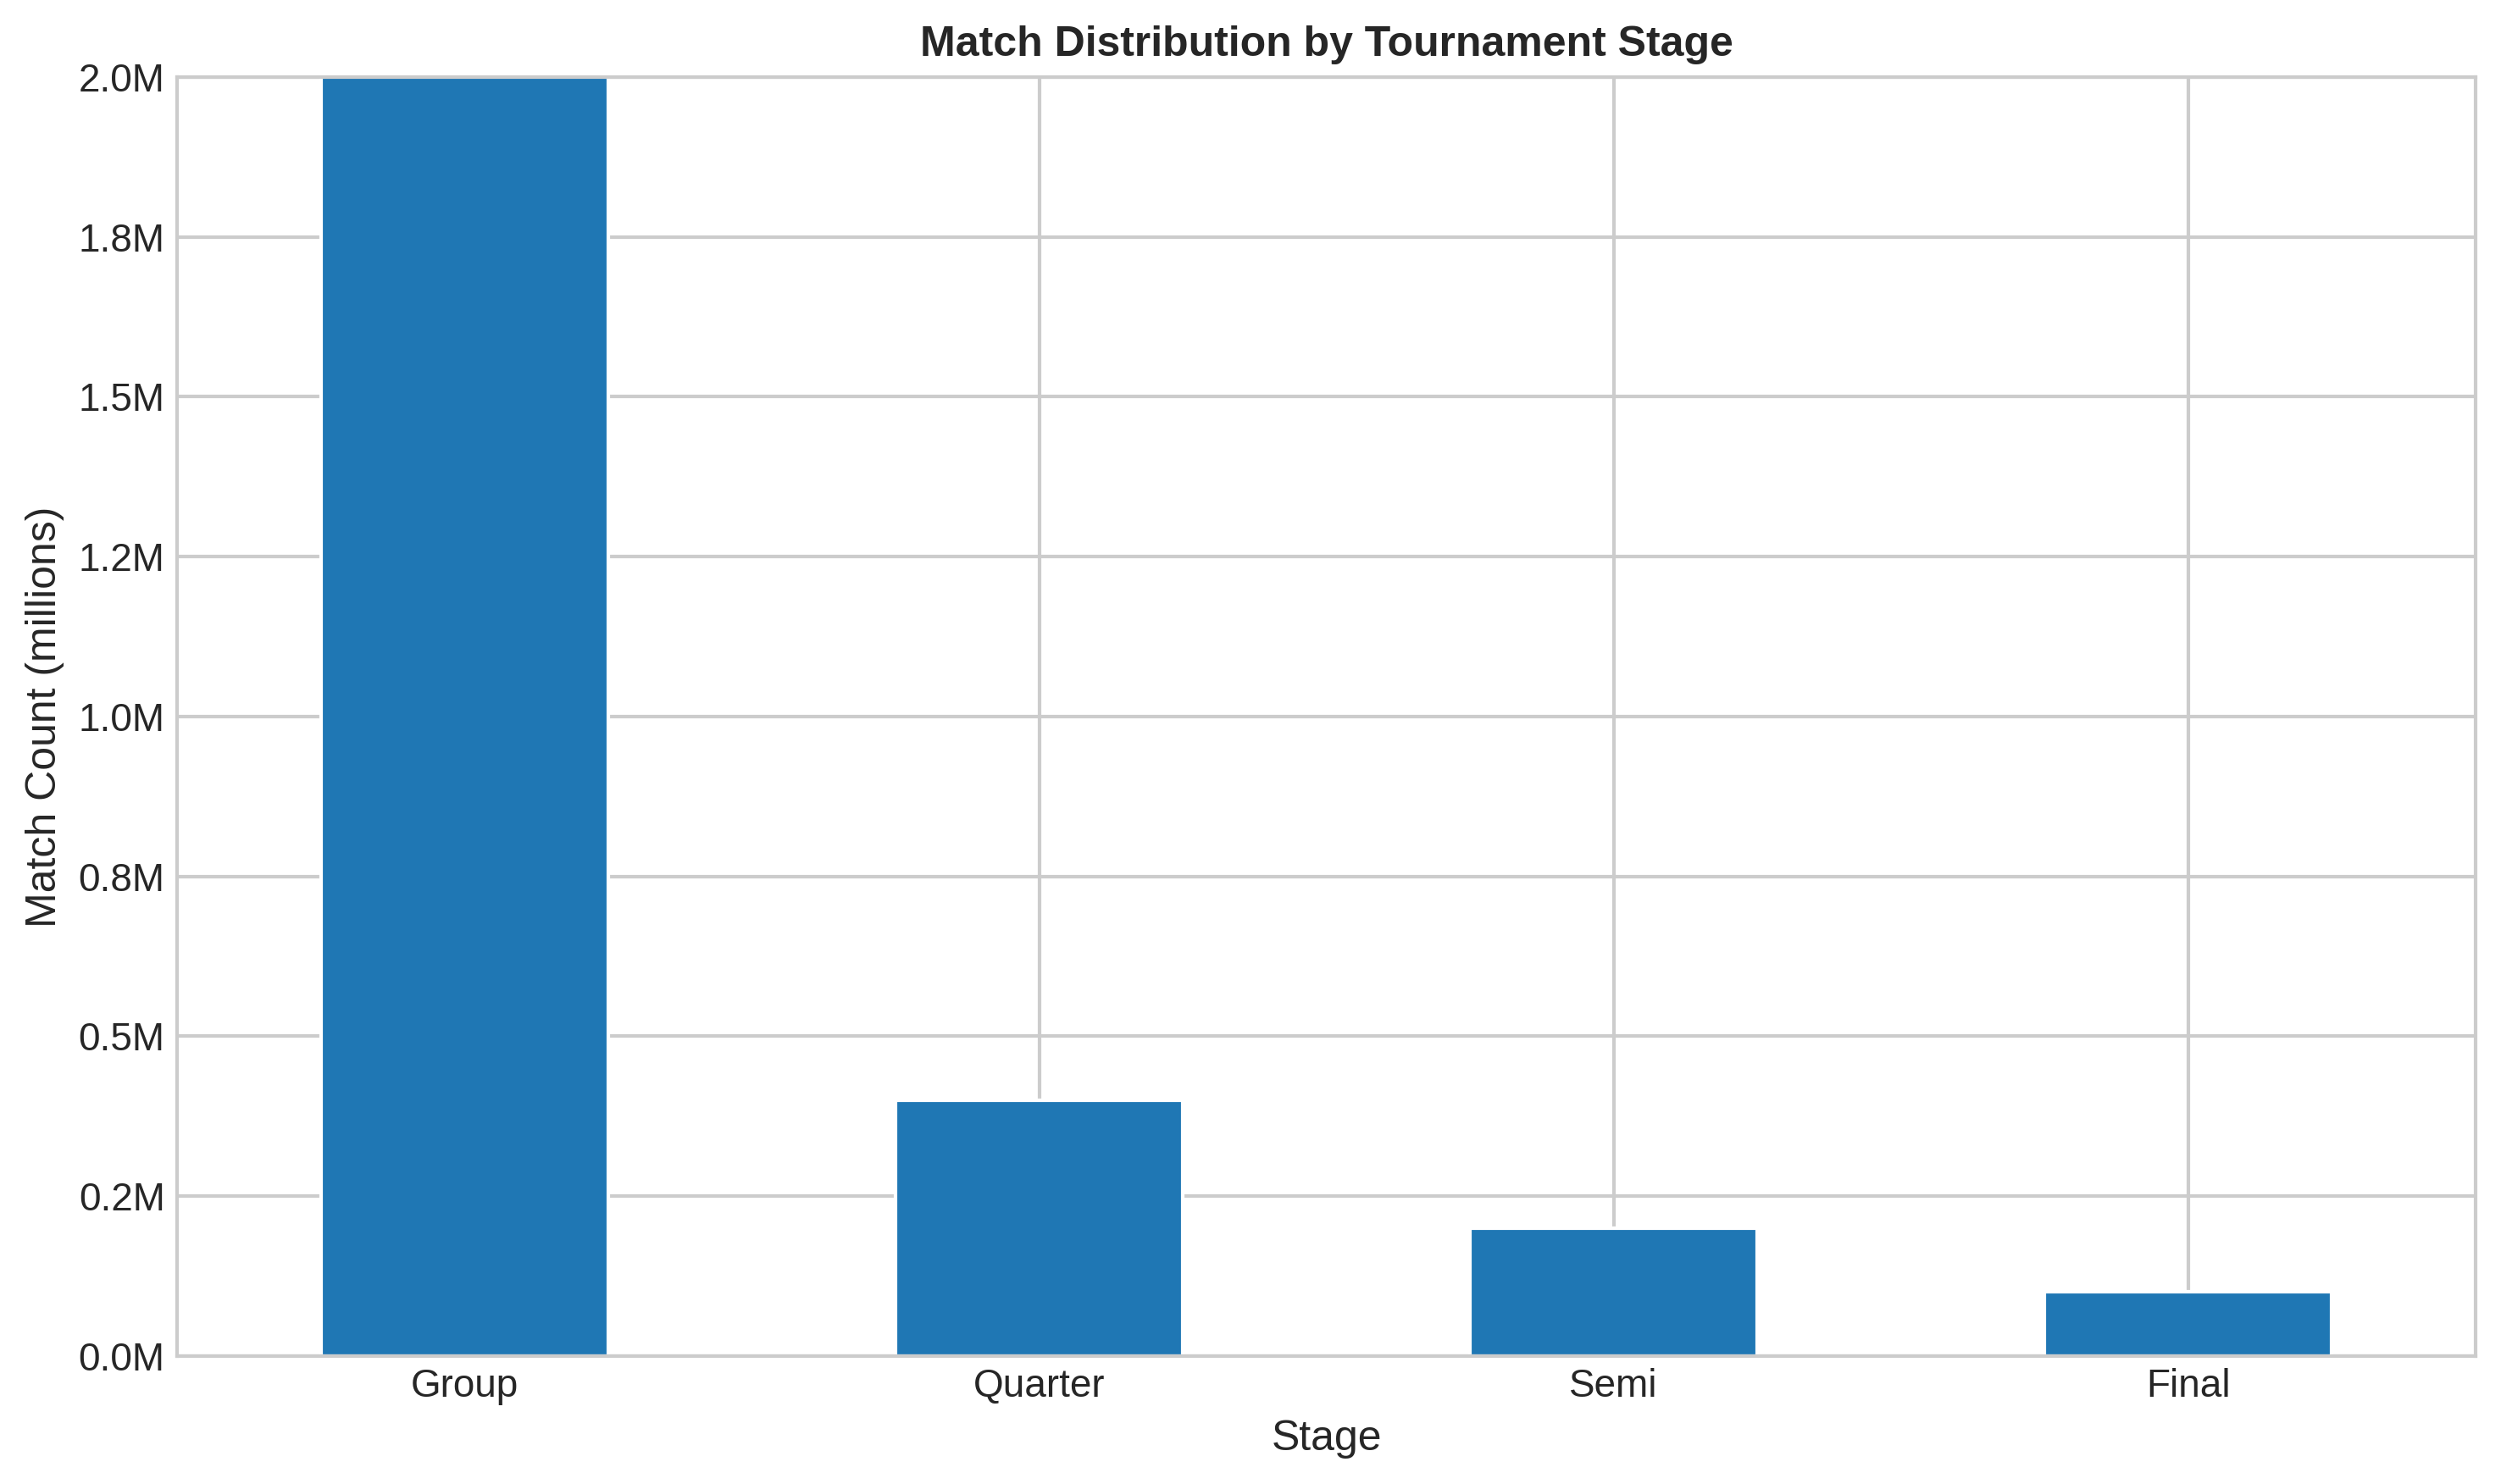

Total Tournaments: 100,000
Matches per Stage:
Round
Group      2,400,000
Quarter      400,000
Semi         200,000
Final        100,000
Name: count, dtype: object


In [7]:
# Block 2: Tournament Overview
tournament_counts = df['Tournament'].nunique()
round_counts = df['Round'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))
round_counts.plot(kind='bar', color=acl_colors[0], ax=ax)
ax.set_title("Match Distribution by Tournament Stage", fontsize=12)
ax.set_xlabel("Stage", fontsize=12)
ax.set_ylabel("Match Count (millions)", fontsize=12)
ax.set_ylim(0, 2000000)
ax.yaxis.set_major_formatter(lambda x, _: f'{x/1000000:.1f}M')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"Total Tournaments: {tournament_counts:,}")
print("Matches per Stage:")
print(round_counts.apply(lambda x: f"{x:,}"))

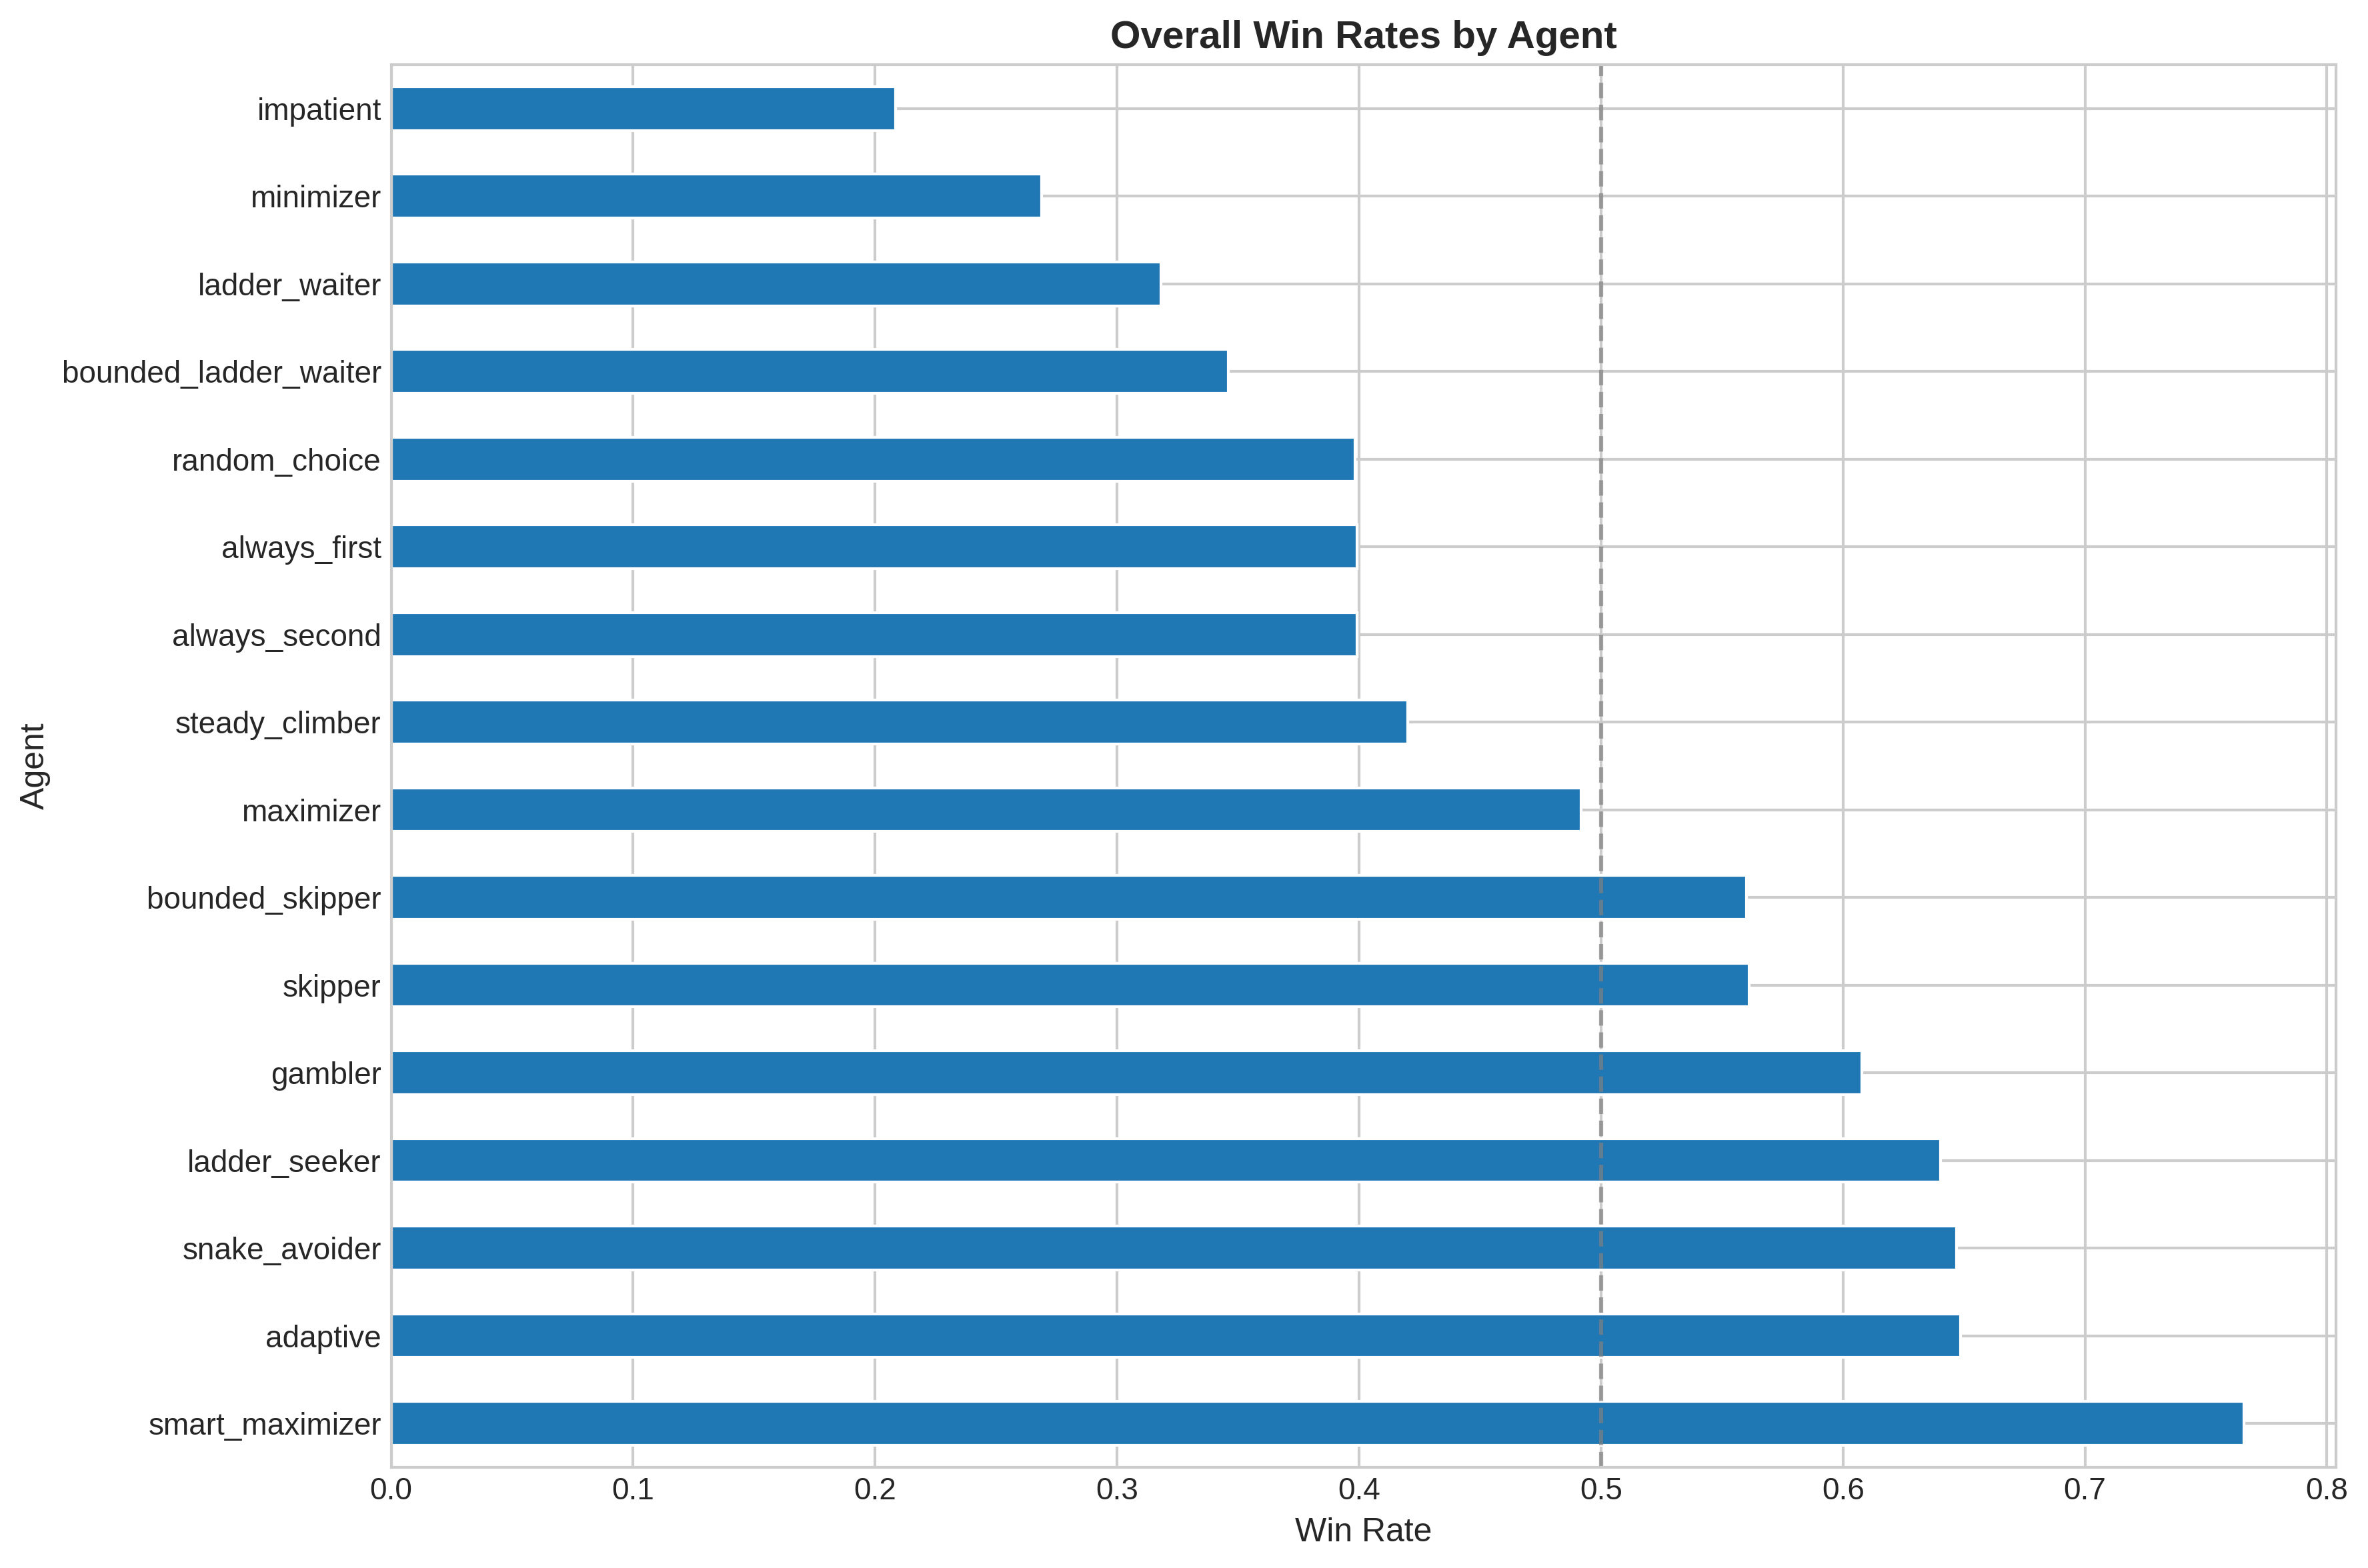

Top Performers:
smart_maximizer: 76.56%
adaptive: 64.86%
snake_avoider: 64.71%

Bottom Performers:
ladder_waiter: 31.81%
minimizer: 26.87%
impatient: 20.86%


In [8]:
# Block 3: Overall Agent Win Rates
agent_win_counts = df['Winner'].value_counts()
total_matches_per_agent = pd.concat([df['Player 1'], df['Player 2']]).value_counts()
win_rates = (agent_win_counts / total_matches_per_agent).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
win_rates.plot(kind='barh', color=acl_colors[0], ax=ax)
ax.set_title("Overall Win Rates by Agent", fontsize=14)
ax.set_xlabel("Win Rate", fontsize=12)
ax.set_ylabel("Agent", fontsize=12)
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Top Performers:")
for agent, rate in win_rates.head(3).items():
    print(f"{agent}: {rate:.2%}")
print("\nBottom Performers:")
for agent, rate in win_rates.tail(3).items():
    print(f"{agent}: {rate:.2%}")


Win Rate Table (%):
                       Group Quarter   Semi  Final
adaptive               68.0%   61.7%  56.9%  51.7%
always_first           41.3%   33.9%  29.8%  27.1%
always_second          41.3%   33.9%  30.4%  27.3%
bounded_ladder_waiter  35.8%   27.7%  22.7%  18.9%
bounded_skipper        59.1%   50.9%  44.1%  39.1%
gambler                63.7%   56.9%  51.6%  47.2%
impatient              21.1%   16.8%  12.5%  11.1%
ladder_seeker          67.0%   60.8%  56.3%  51.4%
ladder_waiter          32.7%   25.1%  21.3%  17.7%
maximizer              51.4%   43.1%  38.8%  35.2%
minimizer              27.4%   21.5%  17.8%  16.8%
random_choice          41.2%   33.9%  29.8%  26.1%
skipper                59.3%   50.6%  44.5%  39.5%
smart_maximizer        79.1%   75.1%  71.5%  69.9%
snake_avoider          68.1%   61.1%  56.2%  50.0%
steady_climber         43.5%   36.1%  31.5%  28.6%


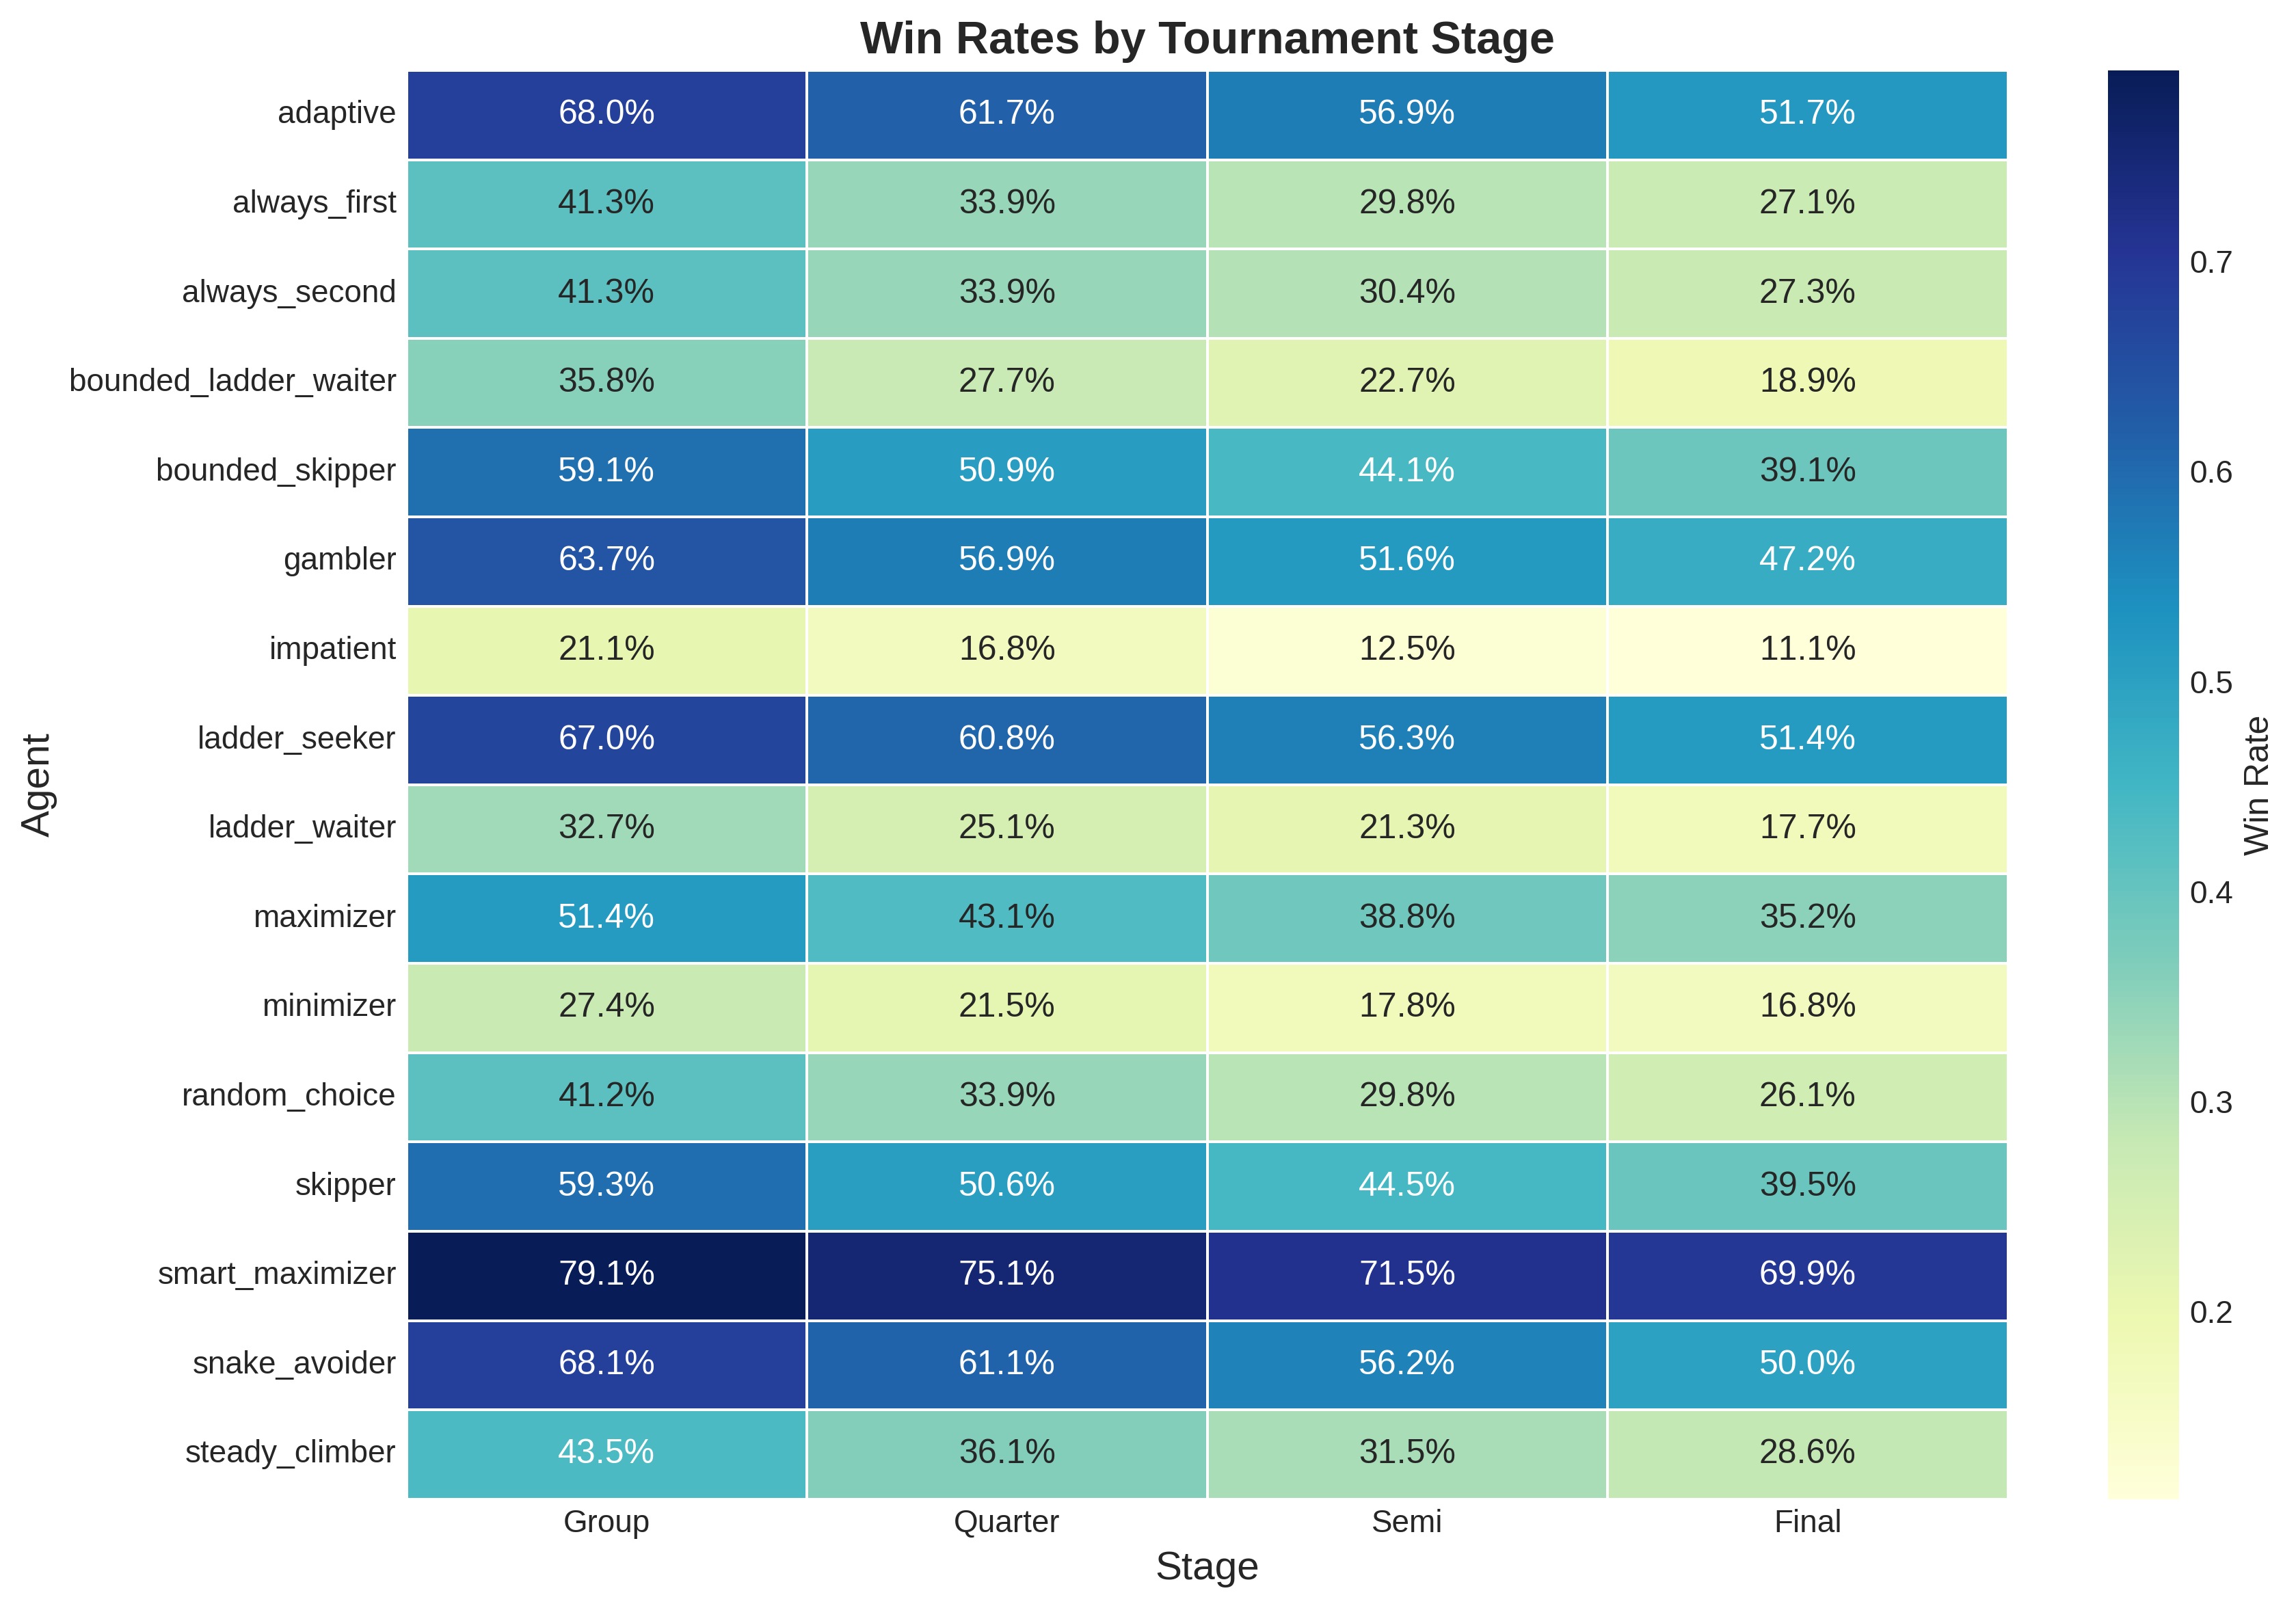

In [10]:
# Compute win rates for each agent at each tournament stage
stage_win_rates = []
agents = df['Player 1'].cat.categories

for agent in agents:
    agent_matches = df[(df['Player 1'] == agent) | (df['Player 2'] == agent)]
    stage_wins = []
    for stage in ['Group', 'Quarter', 'Semi', 'Final']:
        stage_matches = agent_matches[agent_matches['Round'] == stage]
        wins = (stage_matches['Winner'] == agent).sum()
        total = len(stage_matches)
        stage_wins.append(wins / total if total > 0 else 0)
    stage_win_rates.append(stage_wins)

# Create DataFrame
stage_df = pd.DataFrame(stage_win_rates, index=agents, 
                        columns=['Group', 'Quarter', 'Semi', 'Final'])

# Export to CSV
stage_df.to_csv("agent_stage_win_rates.csv")

# Print raw table
print("\nWin Rate Table (%):")
print((stage_df * 100).round(1).astype(str) + '%')

# Visualize as heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(stage_df, annot=True, fmt=".1%", cmap="YlGnBu", 
            cbar_kws={'label': 'Win Rate'}, linewidths=0.5, ax=ax)
ax.set_title("Win Rates by Tournament Stage", fontsize=16, fontweight='bold')
ax.set_xlabel("Stage", fontsize=14)
ax.set_ylabel("Agent", fontsize=14)
plt.tight_layout()
plt.show()

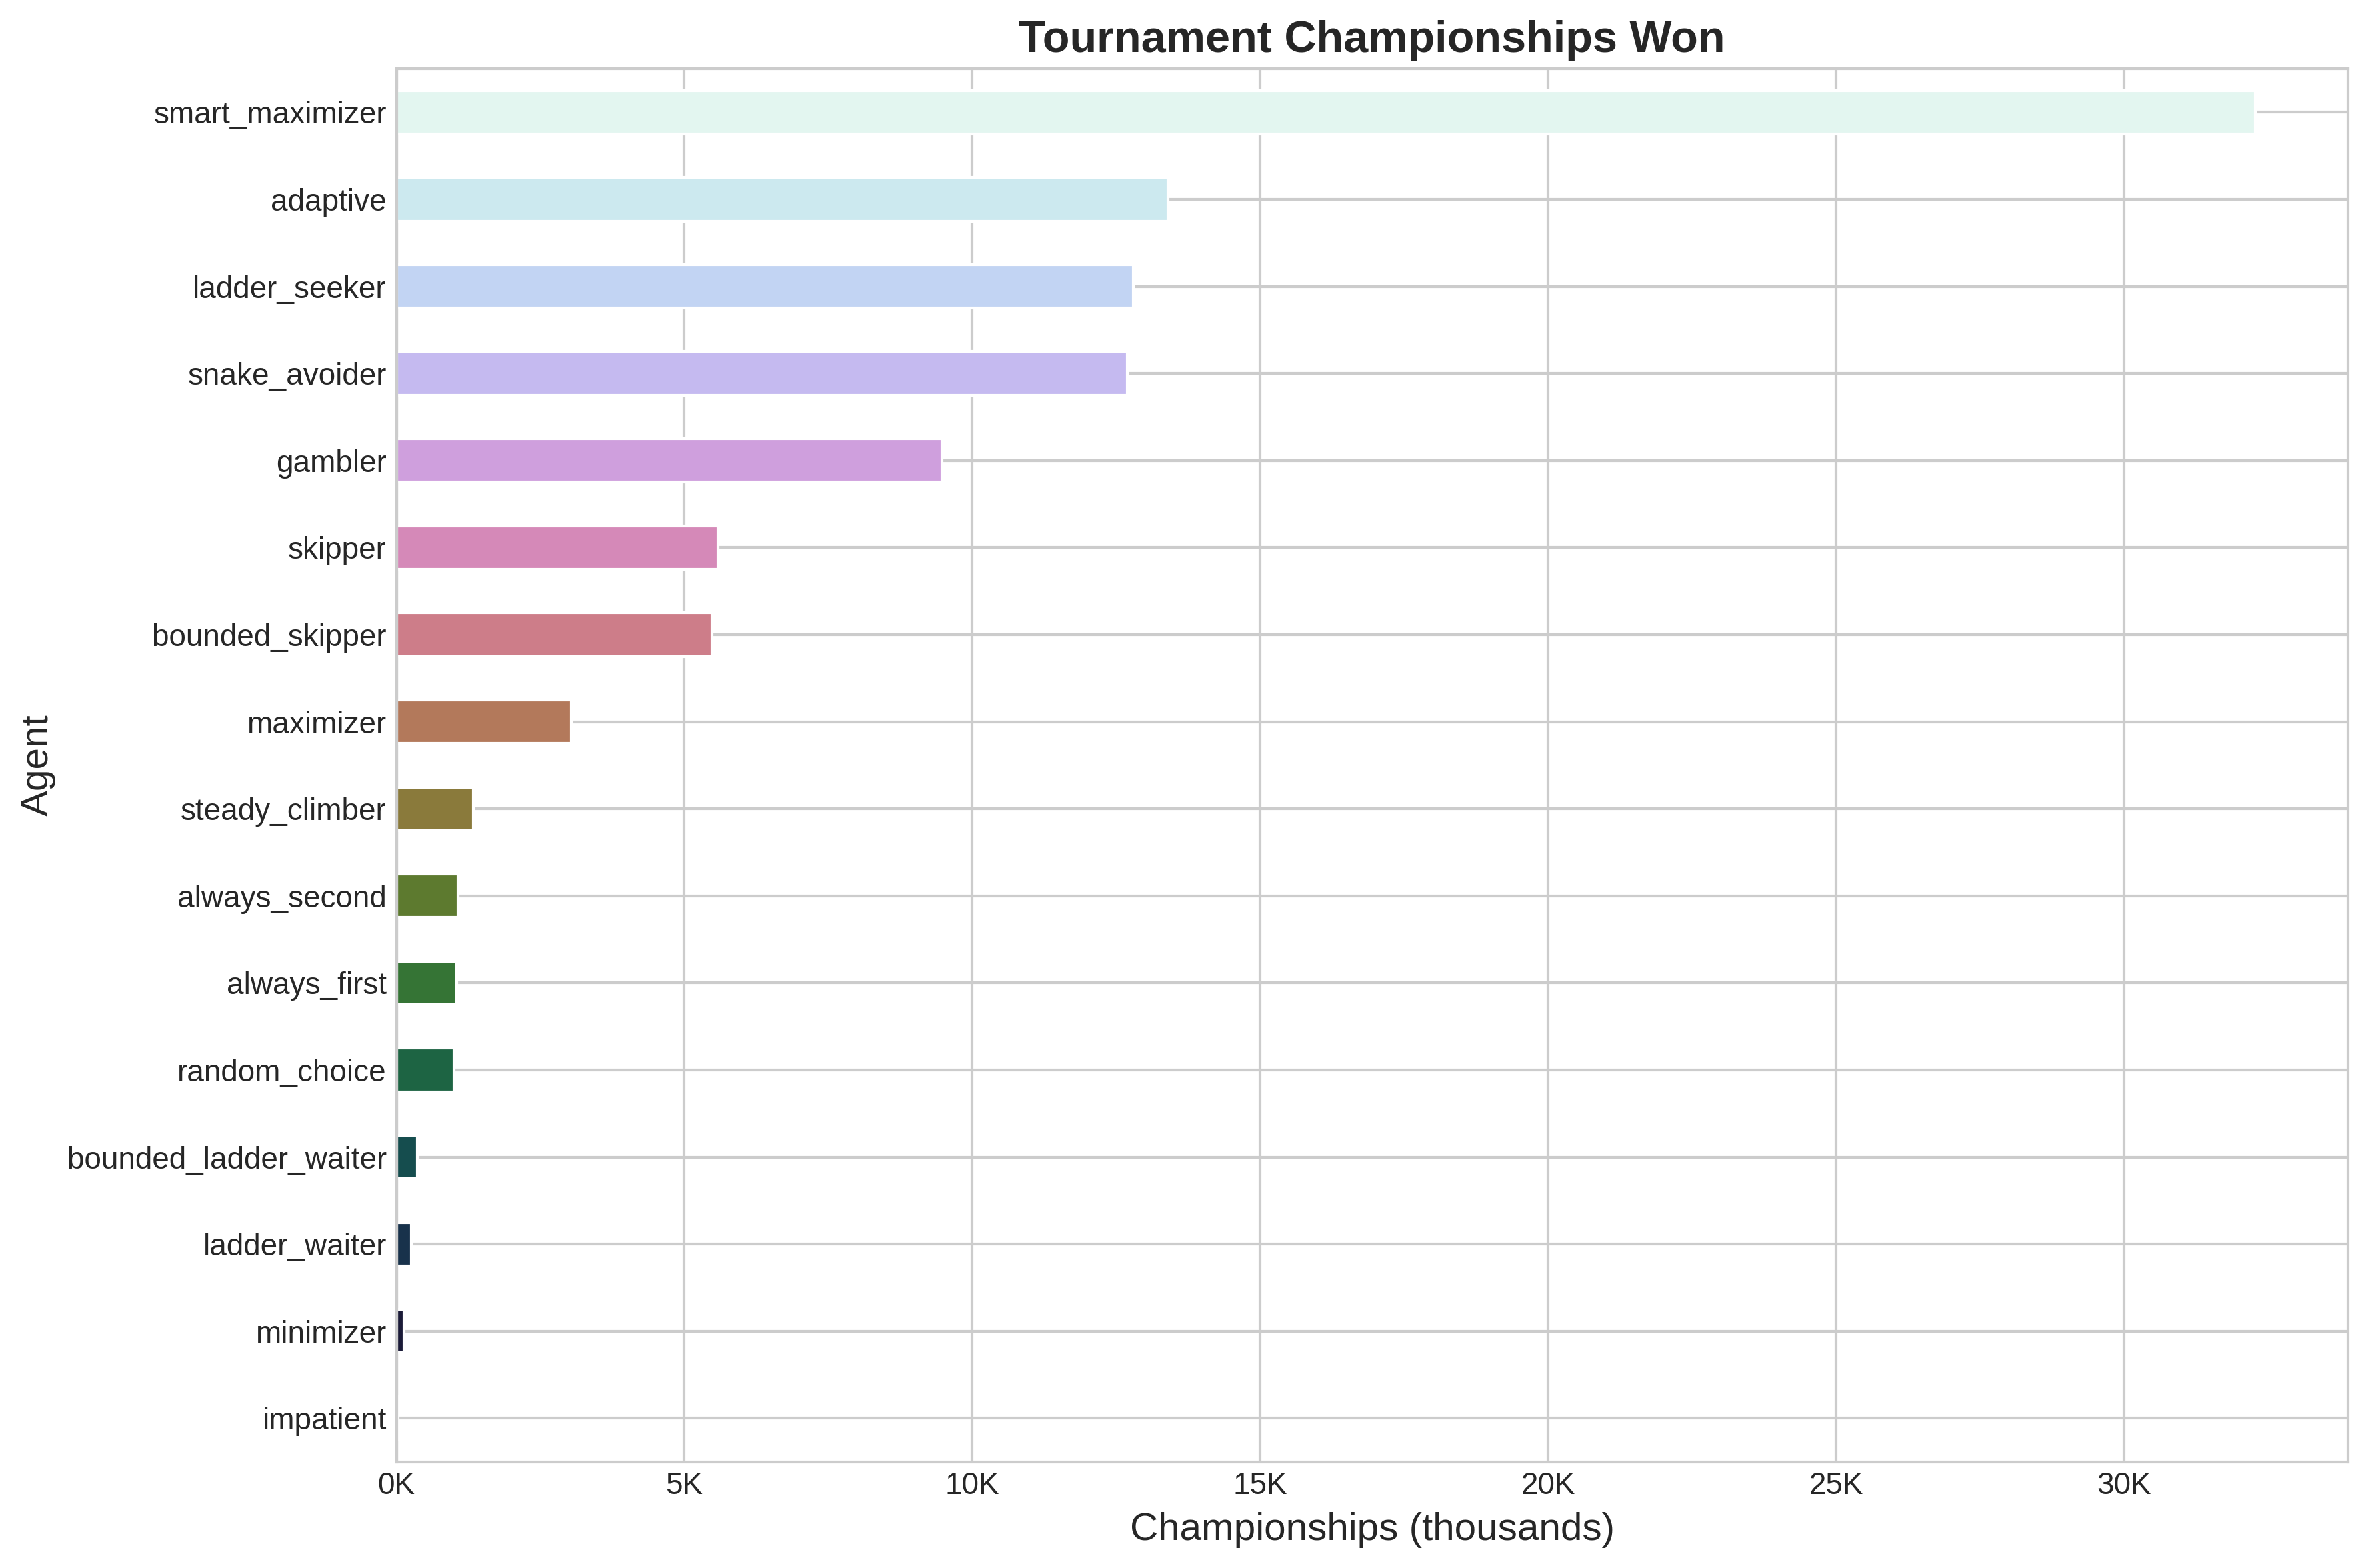

Dominance Ratio: Top 3 agents won 58K tournaments
Championship Share: smart_maximizer (32K)
Efficiency: bounded_ladder_waiter wins with 0K titles


In [12]:
# 1. Data: Identify champions from Final matches
finals = df[df['Round'] == 'Final']
champions = finals['Winner'].value_counts()

# 2. Export to CSV
champions_df = champions.reset_index()
champions_df.columns = ['Agent', 'Championships']
champions_df.to_csv("championship_counts.csv", index=False)

# 3. Visualization: Horizontal bar plot with matte colors
fig, ax = plt.subplots(figsize=(12, 8))
matte_colors = sns.color_palette("cubehelix", len(champions))  # subtle, number-based palette

champions.sort_values().plot(kind='barh', ax=ax, color=matte_colors)

# 4. Aesthetics
ax.set_title("Tournament Championships Won", fontsize=16, fontweight='bold')
ax.set_xlabel("Championships (thousands)", fontsize=14)
ax.set_ylabel("Agent", fontsize=14)
ax.xaxis.set_major_formatter(lambda x, _: f'{x/1000:.0f}K')
plt.tight_layout()
plt.show()

# 5. Insights (print)
print(f"Dominance Ratio: Top 3 agents won {champions.head(3).sum()/1000:.0f}K tournaments")
print(f"Championship Share: smart_maximizer ({champions['smart_maximizer']/1000:.0f}K)")
print(f"Efficiency: bounded_ladder_waiter wins with {champions['bounded_ladder_waiter']/1000:.0f}K titles")

/tmp/ipykernel_36/3702640236.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  turn_stats = df.groupby('Round')['Turns'].describe()[['mean', '50%', 'std']]
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


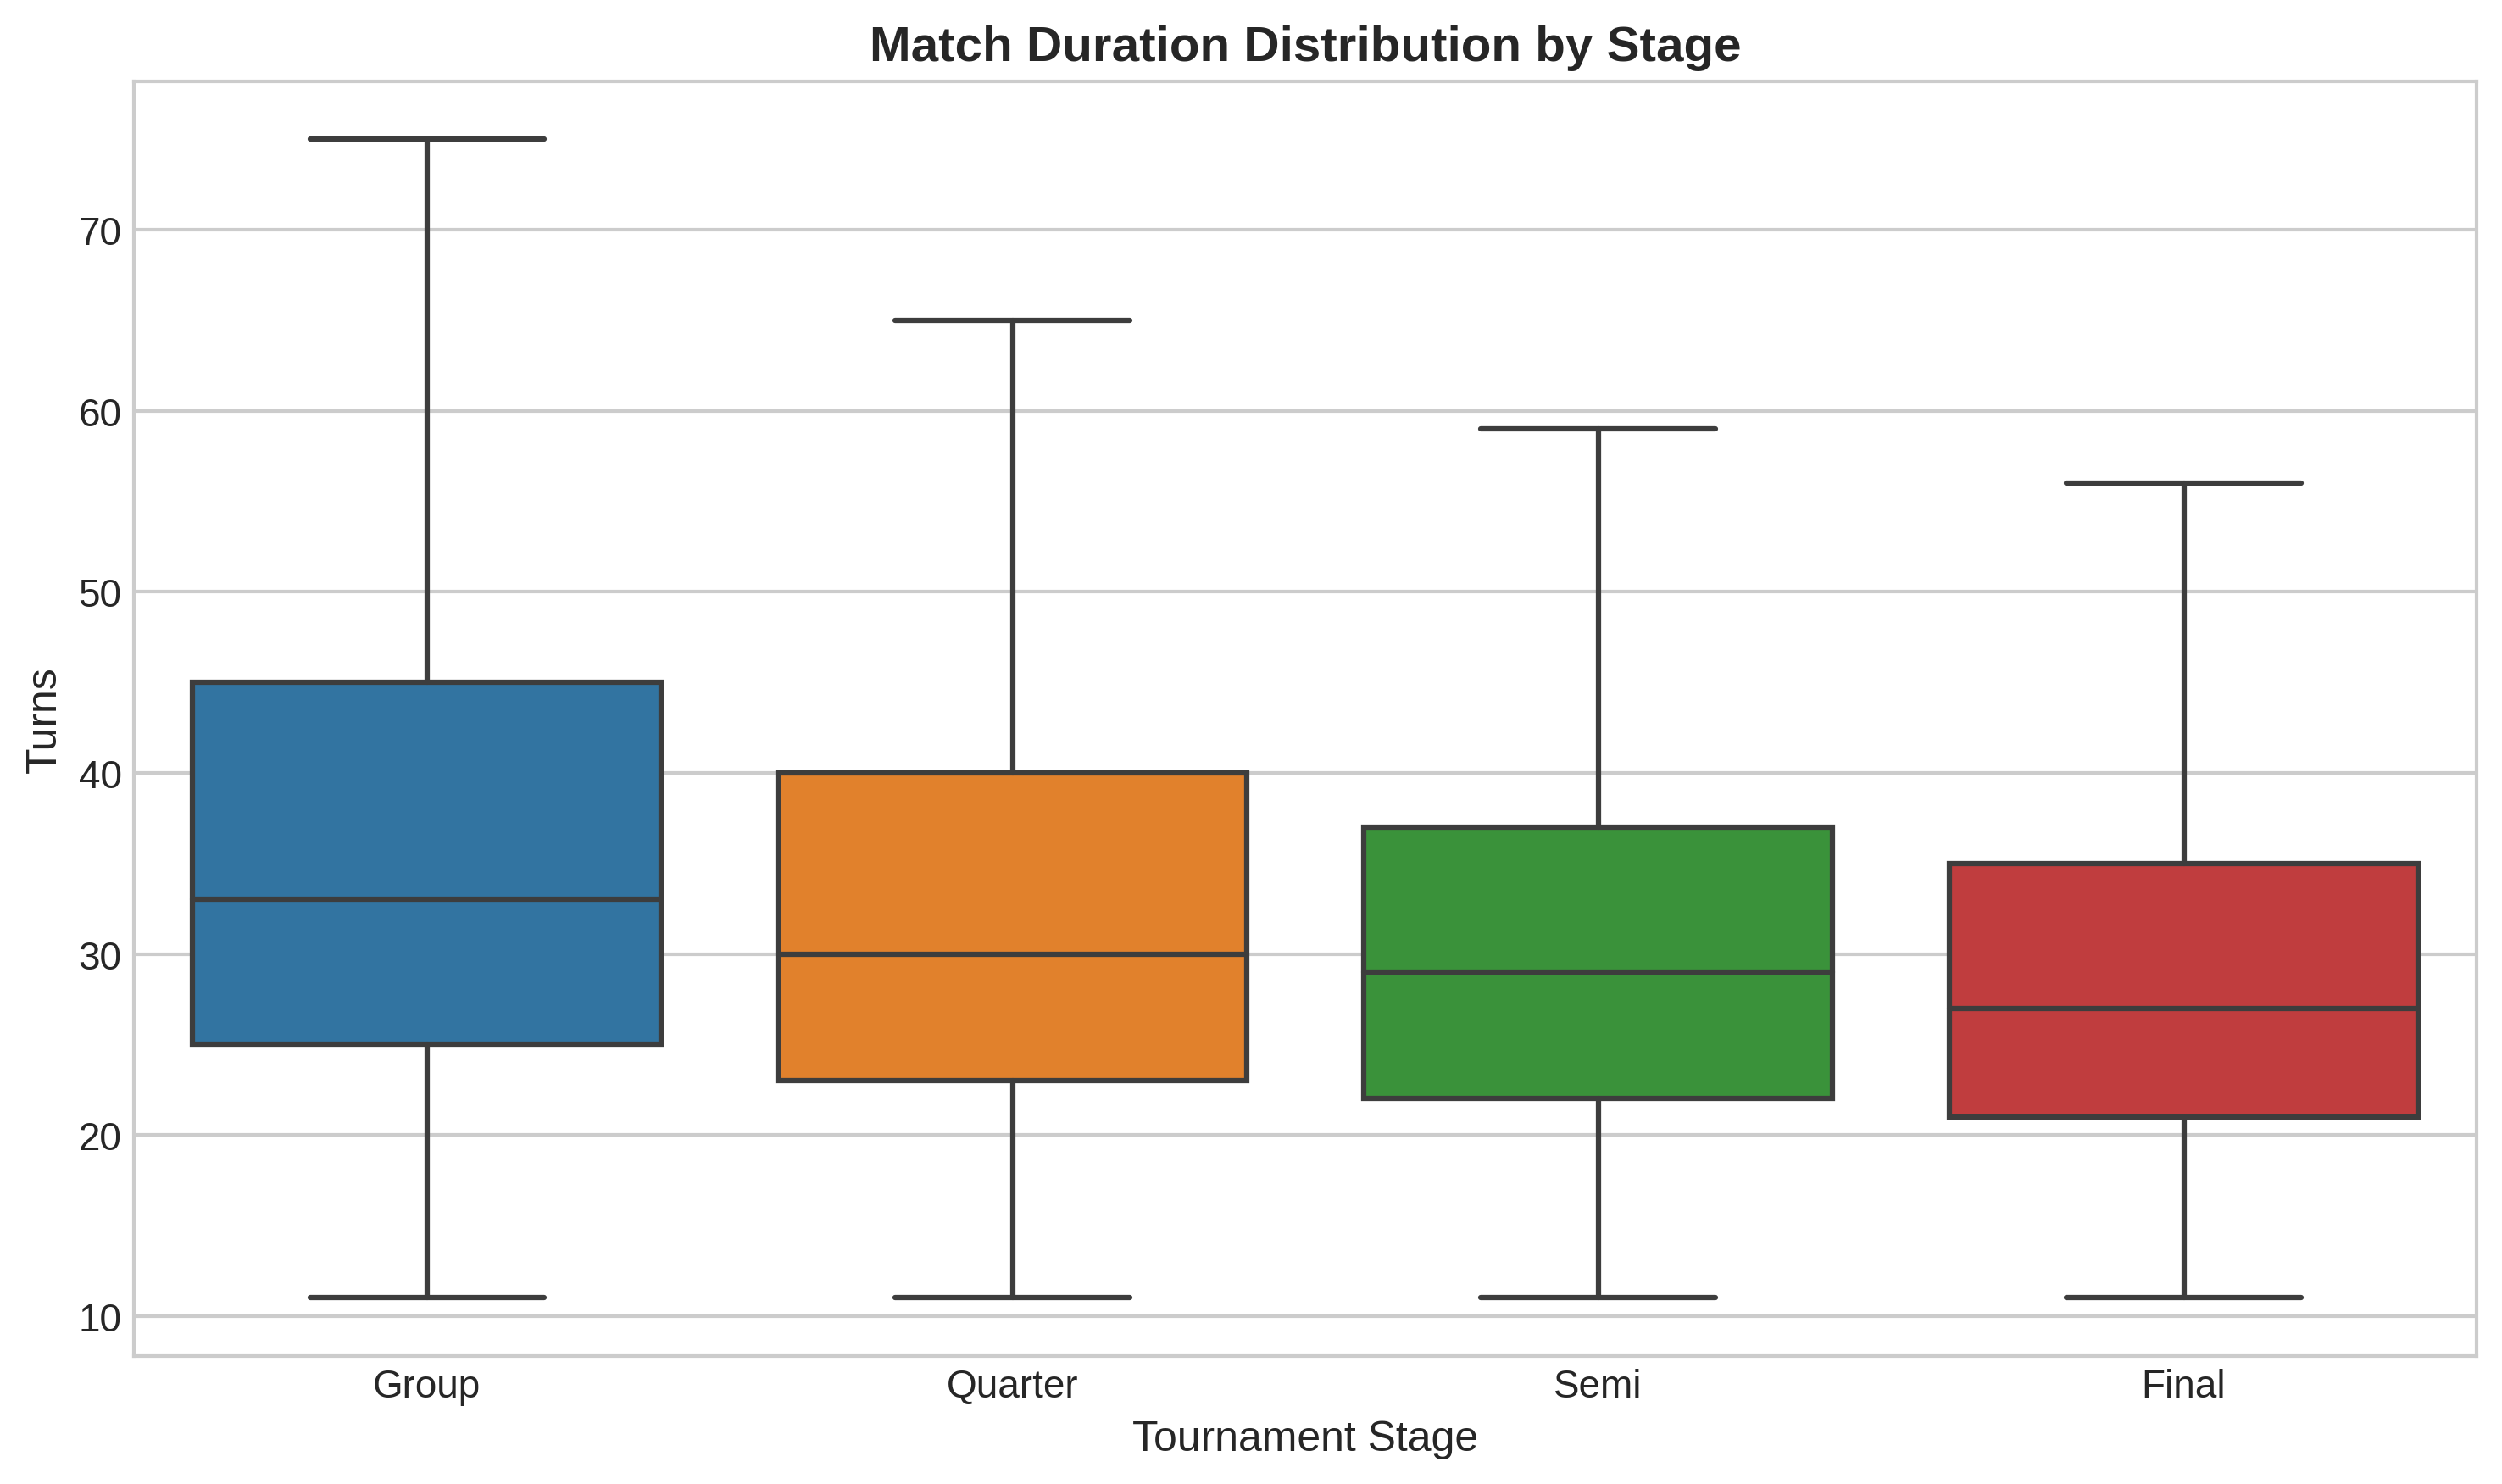

Turn Statistics:
Average Match: 36.6 turns
Stage Differences:
Finals are 0.8x longer than group matches
Volatility: Turn SD increases from 20.4 (Group) to 11.6 (Final)


In [14]:
# Block 6: Match Duration Analysis
turn_stats = df.groupby('Round')['Turns'].describe()[['mean', '50%', 'std']]

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Round', y='Turns', data=df, showfliers=False,
            order=['Group', 'Quarter', 'Semi', 'Final'], ax=ax)
ax.set_title("Match Duration Distribution by Stage", fontsize=14)
ax.set_xlabel("Tournament Stage", fontsize=12)
ax.set_ylabel("Turns", fontsize=12)
plt.tight_layout()
plt.show()

print("Turn Statistics:")
print(f"Average Match: {df['Turns'].mean():.1f} turns")
print("Stage Differences:")
print(f"Finals are {turn_stats.loc['Final','mean']/turn_stats.loc['Group','mean']:.1f}x longer than group matches")
print(f"Volatility: Turn SD increases from {turn_stats.loc['Group','std']:.1f} (Group) to {turn_stats.loc['Final','std']:.1f} (Final)")

# Prepare and export the CSV
turn_stats_export = turn_stats.rename(columns={"50%": "median"})
turn_stats_export.to_csv("match_duration_by_stage.csv")

/tmp/ipykernel_36/649601930.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  turn_win_rates = df.groupby(['Turns_Bin', 'Winning_Agent']).size().unstack().fillna(0)


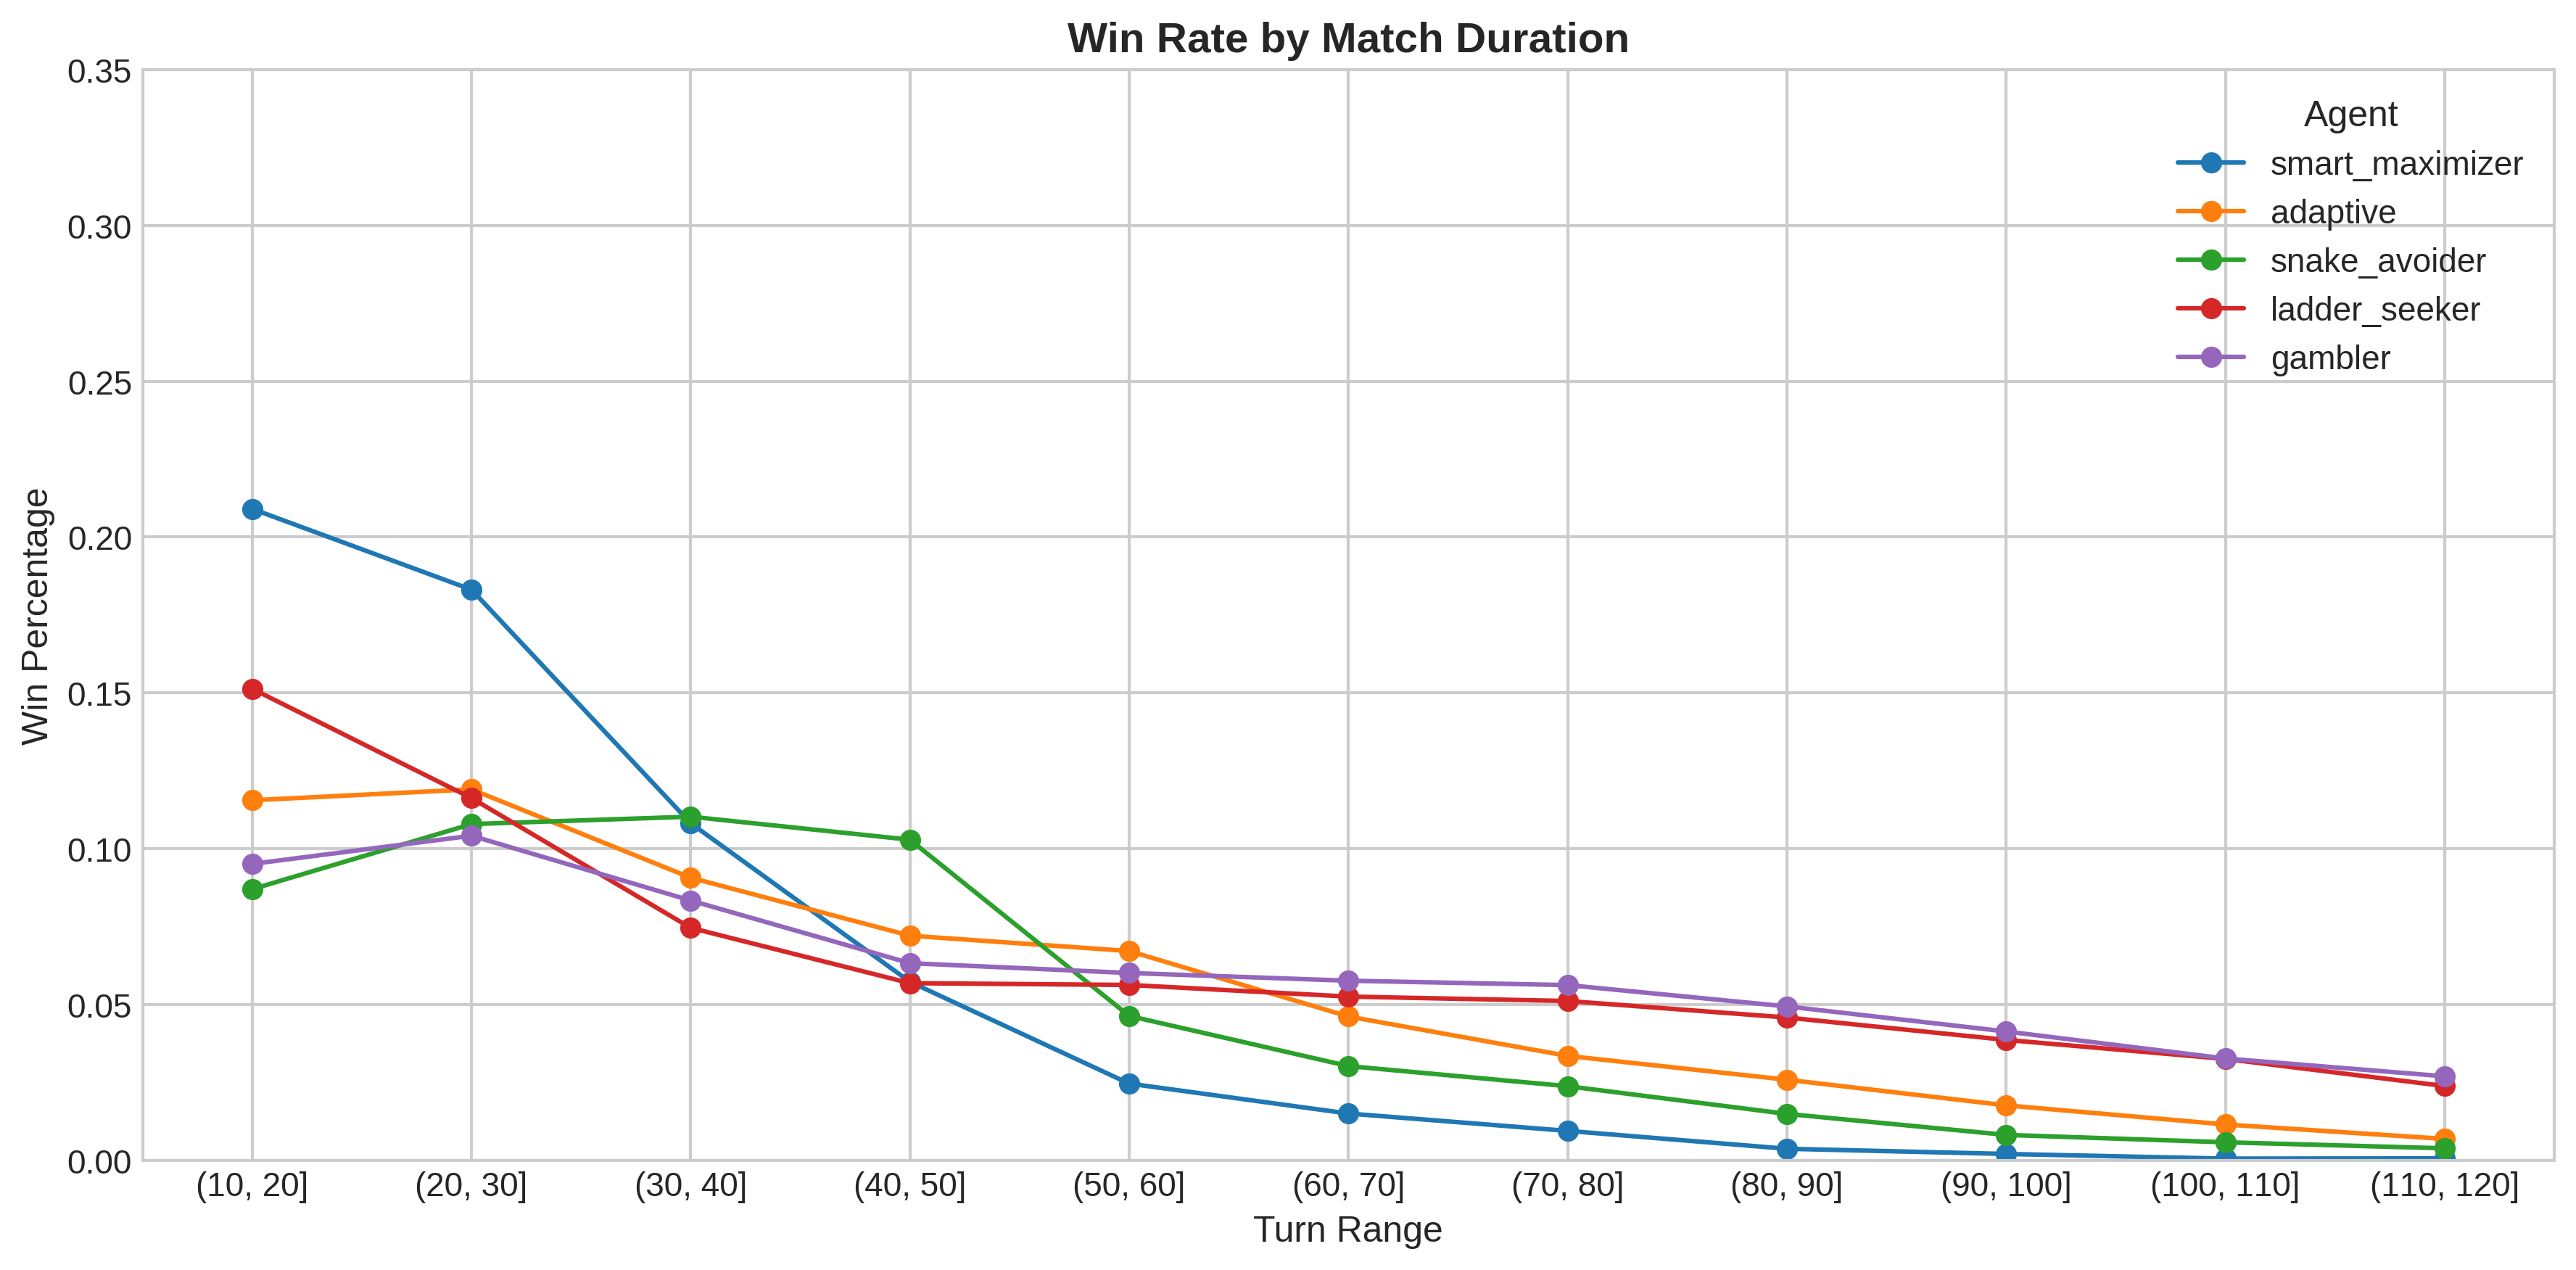

In [17]:
# Block 7: Win Efficiency by Turns
df['Winning_Agent'] = df['Winner']
df['Turns_Bin'] = pd.cut(df['Turns'], bins=range(0, 121, 10))

turn_win_rates = df.groupby(['Turns_Bin', 'Winning_Agent']).size().unstack().fillna(0)
turn_win_rates = turn_win_rates.div(turn_win_rates.sum(axis=1), axis=0)

# Plot top 5 agents
top_agents = win_rates.index[:5]
fig, ax = plt.subplots(figsize=(12, 6))
for agent in top_agents:
    ax.plot(turn_win_rates.index.astype(str), turn_win_rates[agent], 
            label=agent, marker='o')

ax.set_title("Win Rate by Match Duration", fontsize=14)
ax.set_xlabel("Turn Range", fontsize=12)
ax.set_ylabel("Win Percentage", fontsize=12)
ax.legend(title="Agent")
ax.set_ylim(0, 0.35)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Export win efficiency by turn bins to CSV
turn_win_rates.index = turn_win_rates.index.astype(str)  # make bins string for CSV
turn_win_rates.to_csv("win_efficiency_by_turns.csv")


100%|██████████| 3100000/3100000 [02:37<00:00, 19725.81it/s]


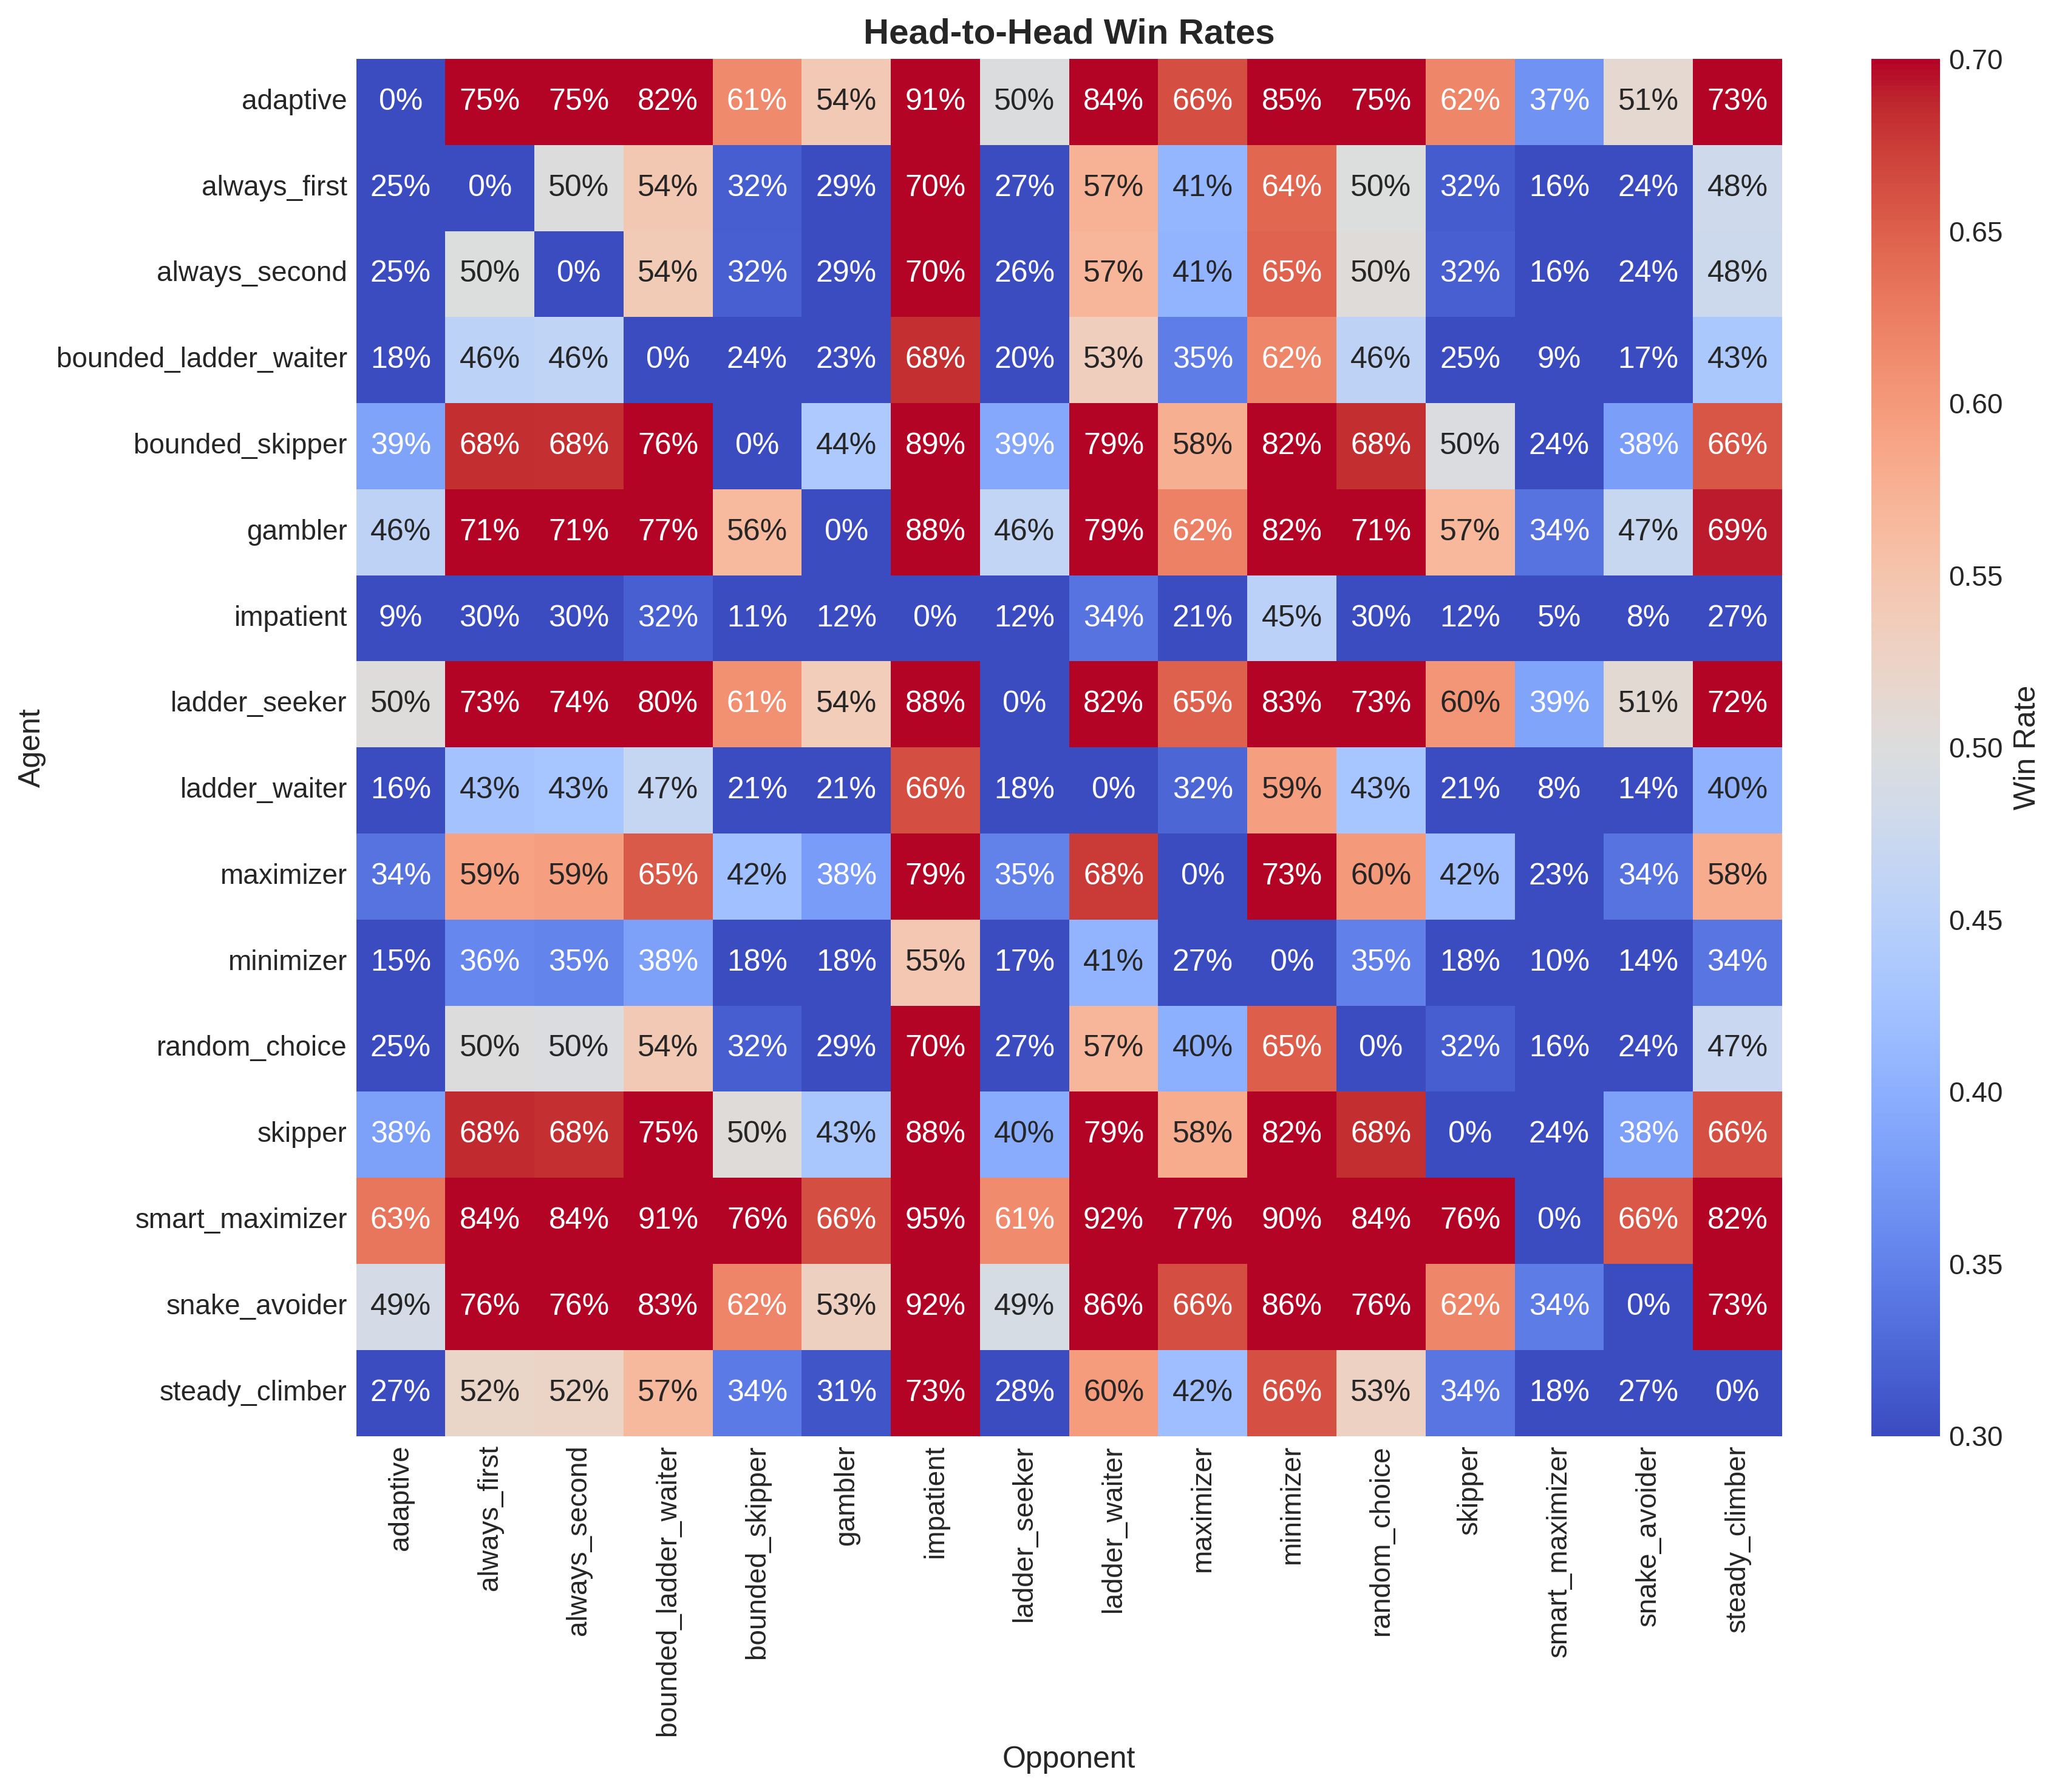

In [18]:
# Block 8: Head-to-Head Performance Matrix
from scipy.sparse import coo_matrix

# Create agent index mapping
agents = df['Player 1'].cat.categories
agent_idx = {agent: i for i, agent in enumerate(agents)}

# Initialize win matrix
n = len(agents)
win_matrix = np.zeros((n, n))
total_matrix = np.zeros((n, n))

# Populate matrices
for _, row in tqdm(df.iterrows(), total=len(df)):
    p1 = row['Player 1']
    p2 = row['Player 2']
    winner = row['Winner']
    
    i = agent_idx[p1]
    j = agent_idx[p2]
    
    total_matrix[i, j] += 1
    total_matrix[j, i] += 1
    
    if winner == p1:
        win_matrix[i, j] += 1
    else:
        win_matrix[j, i] += 1

# Calculate win rates
with np.errstate(divide='ignore', invalid='ignore'):
    win_rates_matrix = np.divide(win_matrix, total_matrix)
    win_rates_matrix = np.nan_to_num(win_rates_matrix, nan=0)

# Visualization
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(win_rates_matrix, annot=True, fmt=".0%", cmap="coolwarm",
            xticklabels=agents, yticklabels=agents, vmin=0.3, vmax=0.7,
            cbar_kws={'label': 'Win Rate'}, ax=ax)
ax.set_title("Head-to-Head Win Rates", fontsize=14)
ax.set_xlabel("Opponent", fontsize=12)
ax.set_ylabel("Agent", fontsize=12)
plt.tight_layout()
plt.show()

In [19]:
# Export head-to-head win rates matrix to CSV
win_rates_df = pd.DataFrame(win_rates_matrix, index=agents, columns=agents)
win_rates_df.to_csv("head_to_head_win_rates.csv")

/tmp/ipykernel_36/1372978763.py:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")
/tmp/ipykernel_36/1372978763.py:50: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


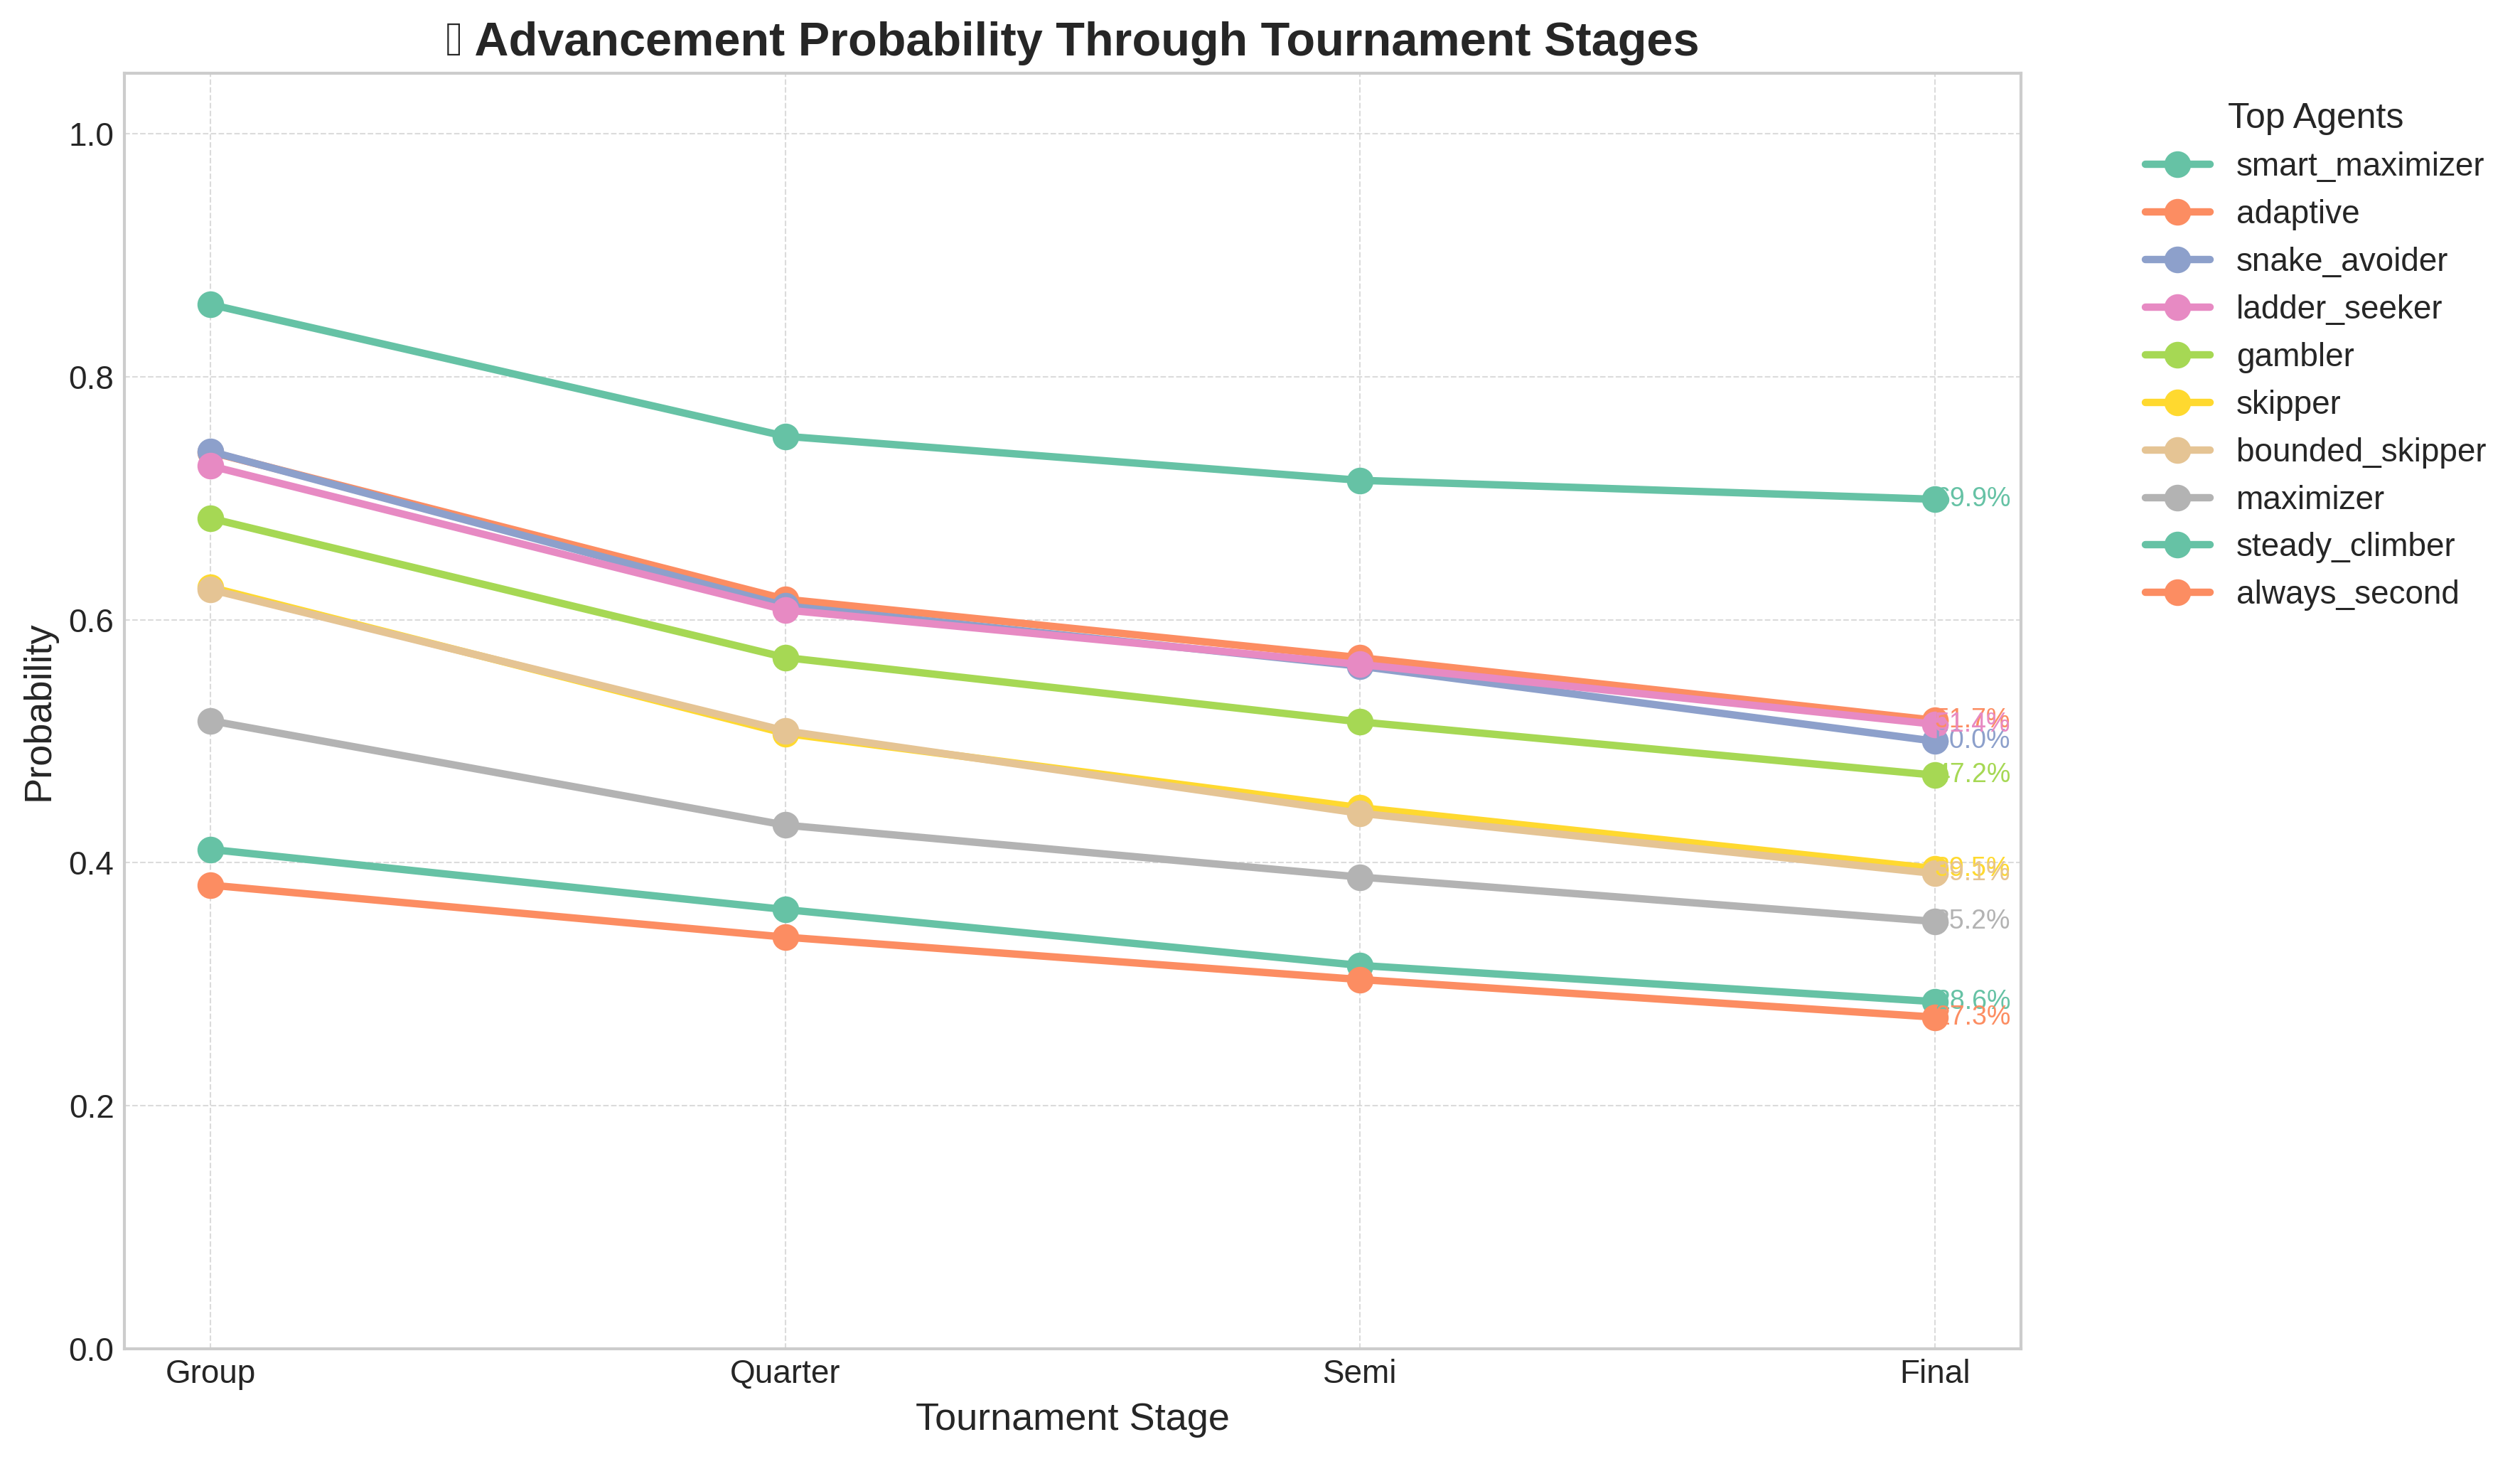

In [22]:

# Calculate advancement probabilities
stages = ['Group', 'Quarter', 'Semi', 'Final']
advancement = pd.DataFrame(index=agents, columns=stages, dtype=float)

for agent in agents:
    group_matches = df[(df['Round'] == 'Group') & 
                      ((df['Player 1'] == agent) | (df['Player 2'] == agent))]
    tournaments_participated = group_matches['Tournament'].nunique()
    
    quarter_appearances = df[(df['Round'] == 'Quarter') & 
                            ((df['Player 1'] == agent) | (df['Player 2'] == agent))]
    advancement.loc[agent, 'Group'] = quarter_appearances['Tournament'].nunique() / tournaments_participated if tournaments_participated else 0

    if not quarter_appearances.empty:
        semi_appearances = df[(df['Round'] == 'Semi') & 
                             ((df['Player 1'] == agent) | (df['Player 2'] == agent)) &
                             (df['Tournament'].isin(quarter_appearances['Tournament']))]
        advancement.loc[agent, 'Quarter'] = semi_appearances['Tournament'].nunique() / quarter_appearances['Tournament'].nunique() if quarter_appearances['Tournament'].nunique() else 0

    if not semi_appearances.empty:
        final_appearances = df[(df['Round'] == 'Final') & 
                              ((df['Player 1'] == agent) | (df['Player 2'] == agent)) &
                              (df['Tournament'].isin(semi_appearances['Tournament']))]
        advancement.loc[agent, 'Semi'] = final_appearances['Tournament'].nunique() / semi_appearances['Tournament'].nunique() if semi_appearances['Tournament'].nunique() else 0

    if not final_appearances.empty:
        wins = (final_appearances['Winner'] == agent).sum()
        advancement.loc[agent, 'Final'] = wins / len(final_appearances) if len(final_appearances) else 0

# Export to CSV
advancement.to_csv("advancement_probability.csv")

# ⬇️ Clean Aesthetic Plot
plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))
palette = sns.color_palette("Set2", n_colors=10)

for i, agent in enumerate(win_rates.index[:10]):
    y_vals = advancement.loc[agent].values.astype(float)
    ax.plot(stages, y_vals, label=agent, marker='o', linewidth=2.5, markersize=8, color=palette[i])
    ax.text(stages[-1], y_vals[-1], f'{y_vals[-1]*100:.1f}%', fontsize=9, color=palette[i], va='center')

# Formatting
ax.set_title("🎯 Advancement Probability Through Tournament Stages", fontsize=16, fontweight='bold')
ax.set_xlabel("Tournament Stage", fontsize=13)
ax.set_ylabel("Probability", fontsize=13)
ax.set_ylim(0, 1.05)
ax.legend(title="Top Agents", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
!pip install C

/tmp/ipykernel_36/2414587403.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'Avg Turns': df.groupby('Winner')['Turns'].mean()[agents],
/tmp/ipykernel_36/2414587403.py:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/tmp/ipykernel_36/2414587403.py:42: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


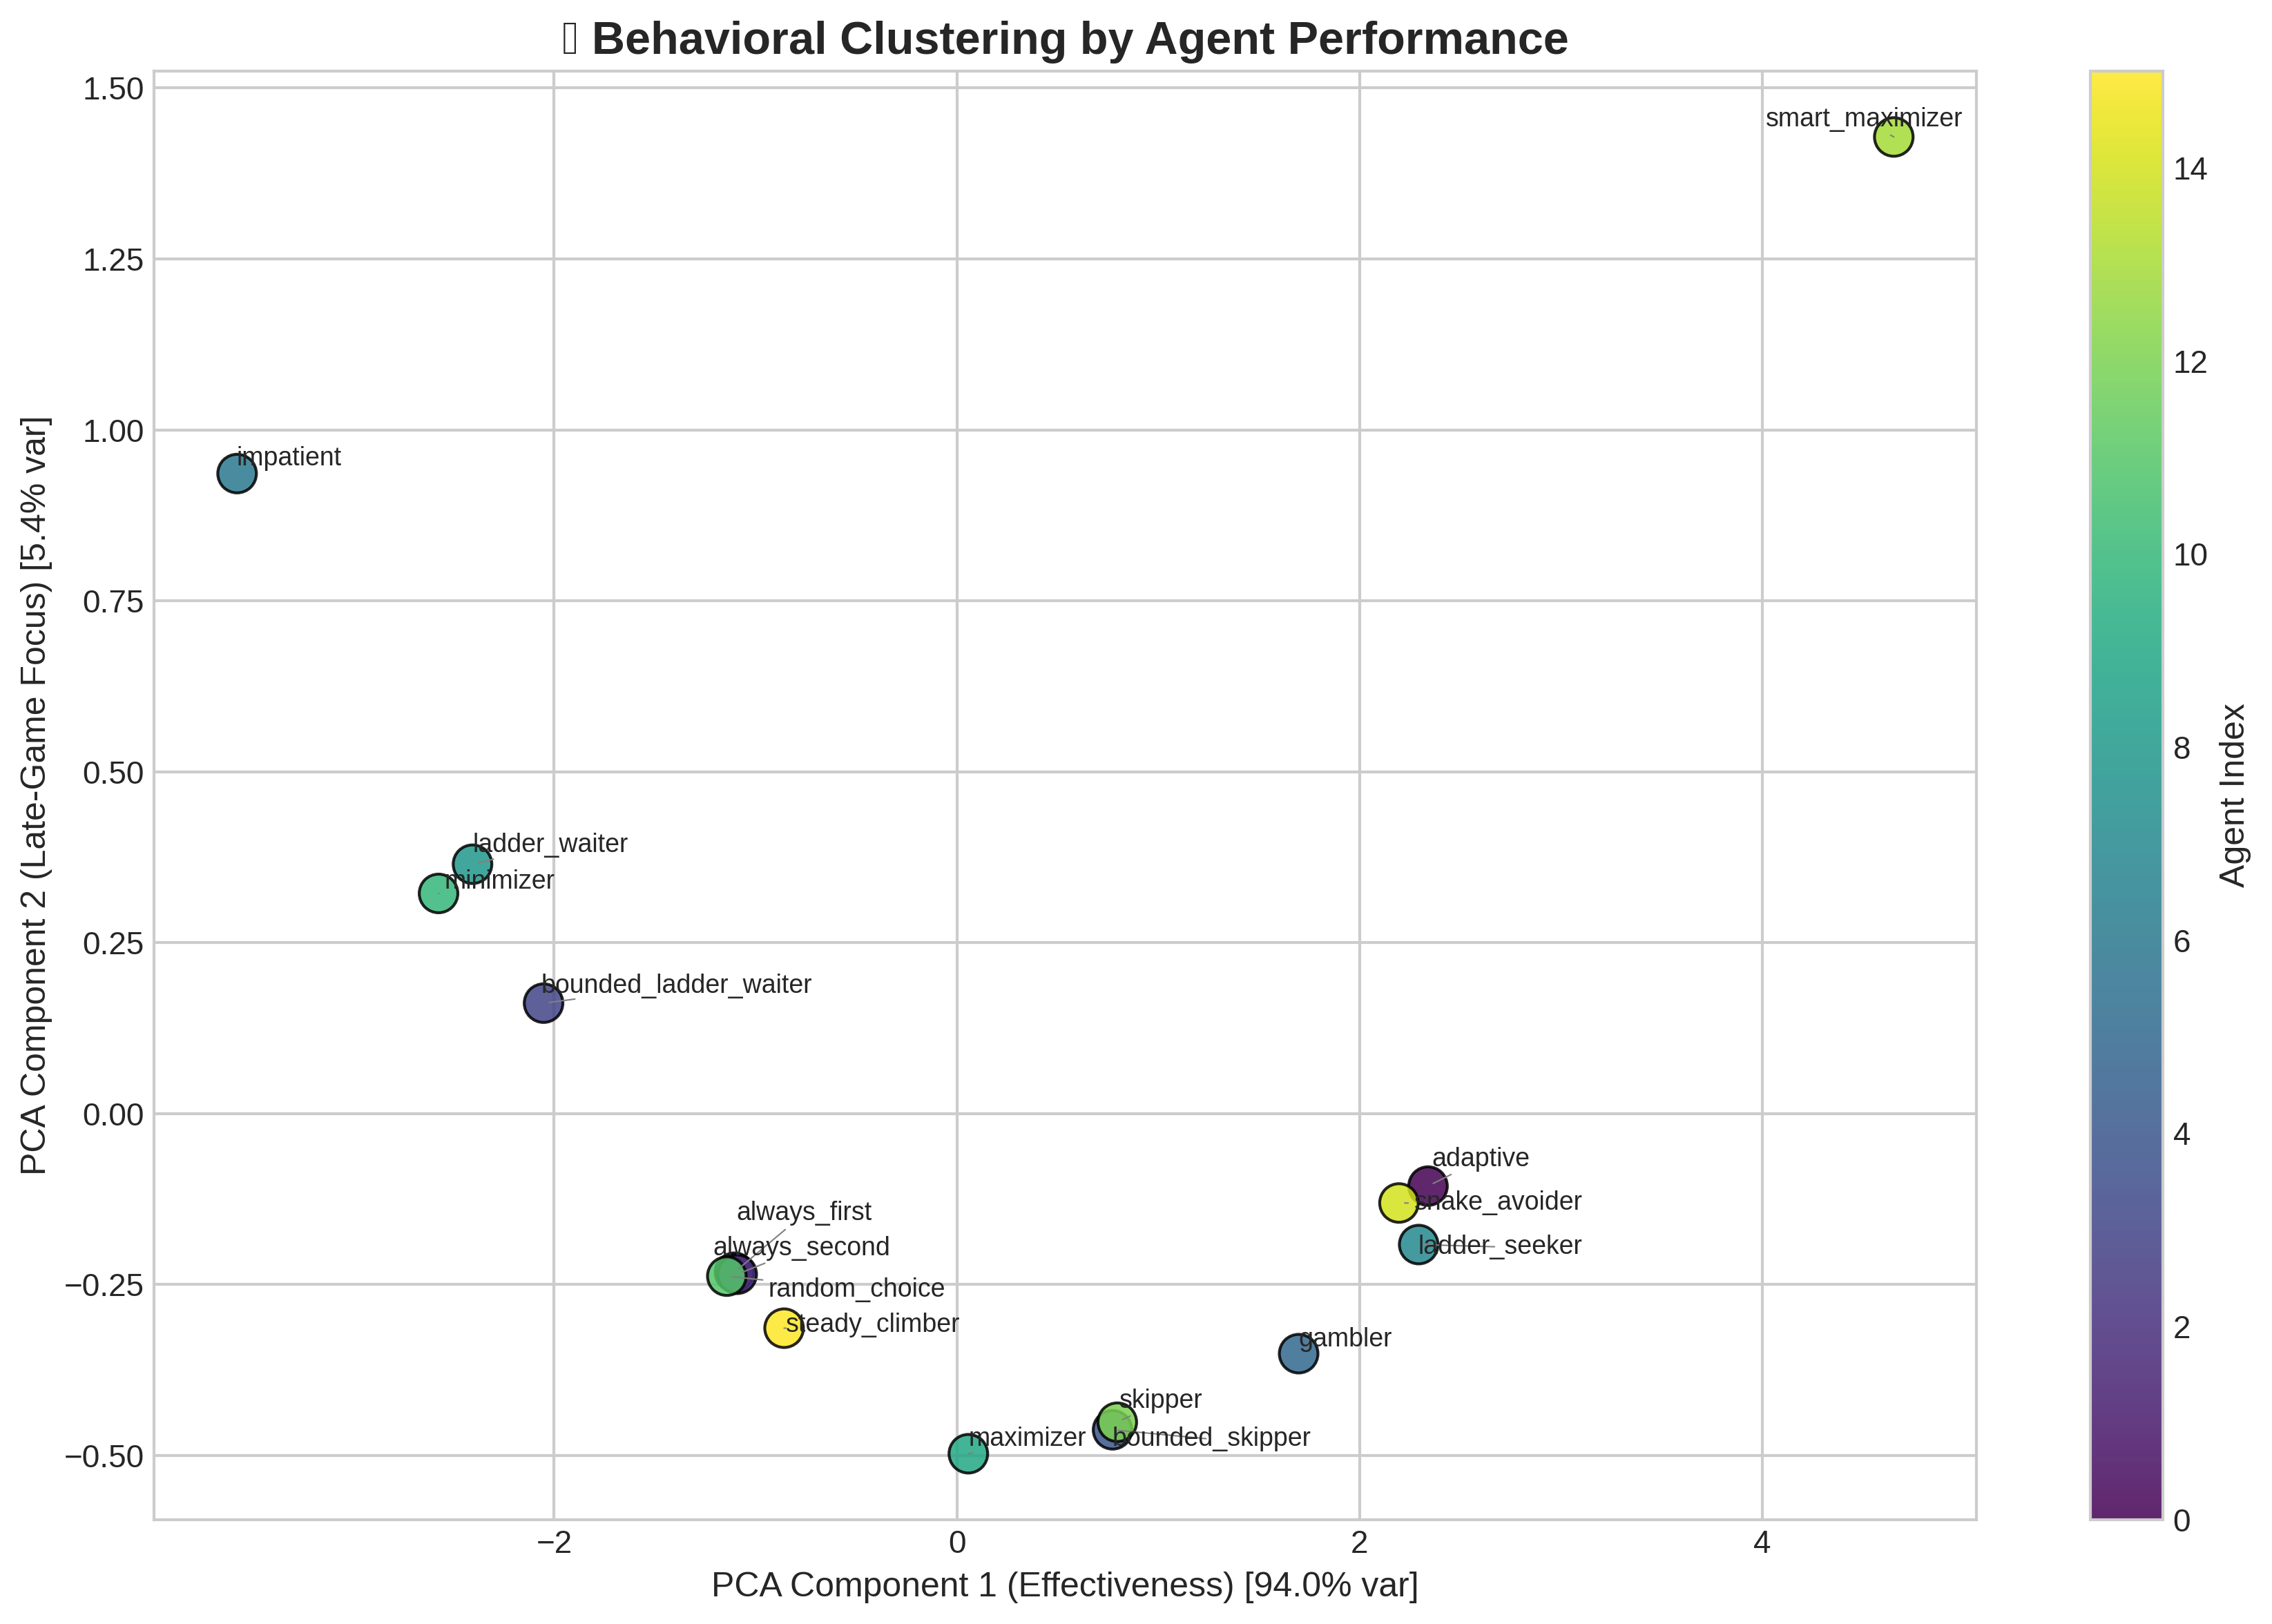

PCA Interpretation:
Component 1: General effectiveness (variance: 94.0%)
Component 2: Late-game specialization (variance: 5.4%)


In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text

# Create performance matrix
metrics = pd.DataFrame({
    'Win Rate': win_rates,
    'Group Advance': advancement['Group'],
    'Final Rate': champions / 1000,
    'Avg Turns': df.groupby('Winner')['Turns'].mean()[agents],
    'Late Game Win Rate': stage_df['Final']
}).fillna(0)

# Normalize + PCA
scaler = StandardScaler()
scaled_metrics = scaler.fit_transform(metrics)
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_metrics)

# Save PCA results
pca_df = pd.DataFrame(pca_results, columns=["PCA_1", "PCA_2"], index=agents)
pca_df = pd.concat([pca_df, metrics], axis=1)
pca_df.to_csv("behavioral_clustering_pca.csv")

# 📊 Better Plot with label adjustment
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(pca_df["PCA_1"], pca_df["PCA_2"], 
                     c=range(len(pca_df)), cmap="viridis", s=180, edgecolors='k', alpha=0.85)

# Smart label placement
texts = []
for i, agent in enumerate(pca_df.index):
    texts.append(ax.text(pca_df.iloc[i, 0], pca_df.iloc[i, 1], agent, fontsize=9))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Formatting
ax.set_title("🧠 Behavioral Clustering by Agent Performance", fontsize=16, fontweight='bold')
ax.set_xlabel(f"PCA Component 1 (Effectiveness) [{pca.explained_variance_ratio_[0]*100:.1f}% var]", fontsize=12)
ax.set_ylabel(f"PCA Component 2 (Late-Game Focus) [{pca.explained_variance_ratio_[1]*100:.1f}% var]", fontsize=12)
plt.colorbar(scatter, label='Agent Index')
plt.tight_layout()
plt.show()

# Interpretation
print("PCA Interpretation:")
print(f"Component 1: General effectiveness (variance: {pca.explained_variance_ratio_[0]:.1%})")
print(f"Component 2: Late-game specialization (variance: {pca.explained_variance_ratio_[1]:.1%})")


/tmp/ipykernel_36/4283542229.py:20: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


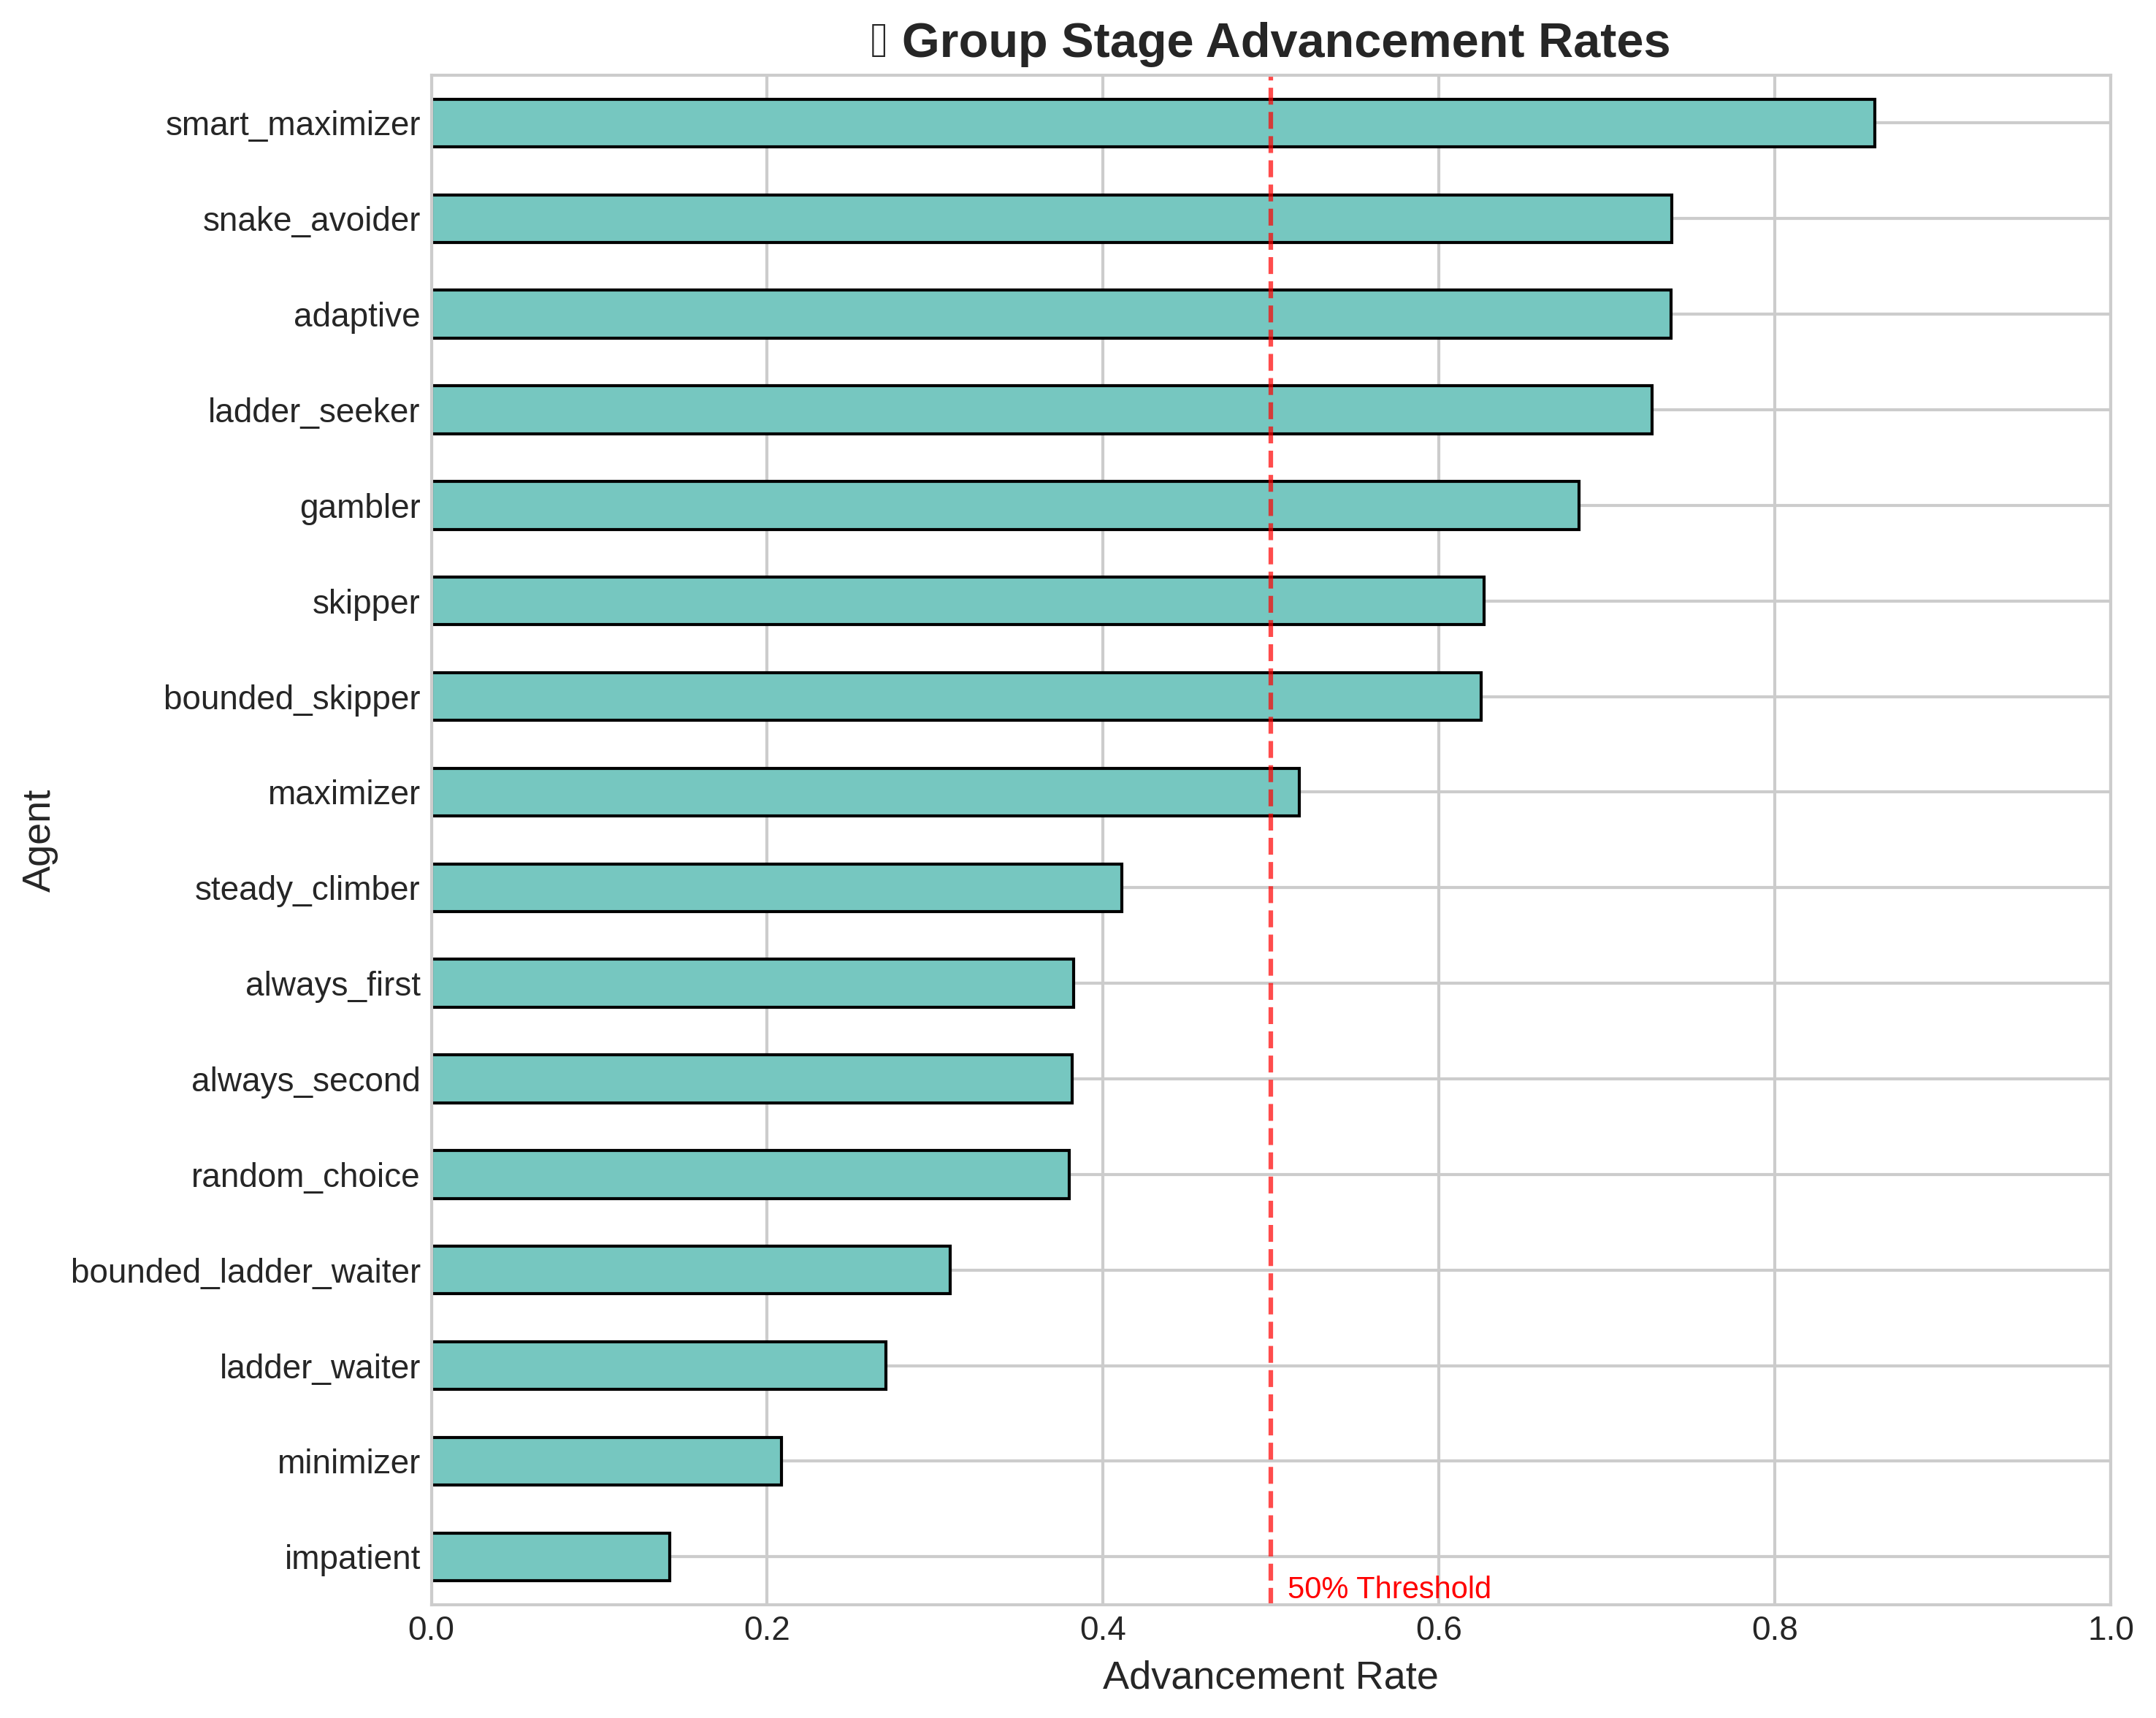

In [28]:
# Sort advancement by group stage
group_adv = advancement['Group'].sort_values(ascending=True)

# Export to CSV
group_adv.to_frame(name='Group_Advancement_Rate').to_csv("group_stage_advancement.csv")

# 📊 Horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 8))
group_adv.plot(kind='barh', color='#76C7C0', ax=ax, edgecolor='black')

# Add threshold line
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.7)
ax.text(0.51, -0.5, '50% Threshold', color='red', fontsize=10, va='bottom')

# Labels and title
ax.set_title("🚀 Group Stage Advancement Rates", fontsize=16, fontweight='bold')
ax.set_xlabel("Advancement Rate", fontsize=13)
ax.set_ylabel("Agent", fontsize=13)
ax.set_xlim(0, 1.0)
plt.tight_layout()
plt.show()

/tmp/ipykernel_36/823751851.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = metrics['Avg Turns'][i]
/tmp/ipykernel_36/823751851.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = metrics['Win Rate'][i]


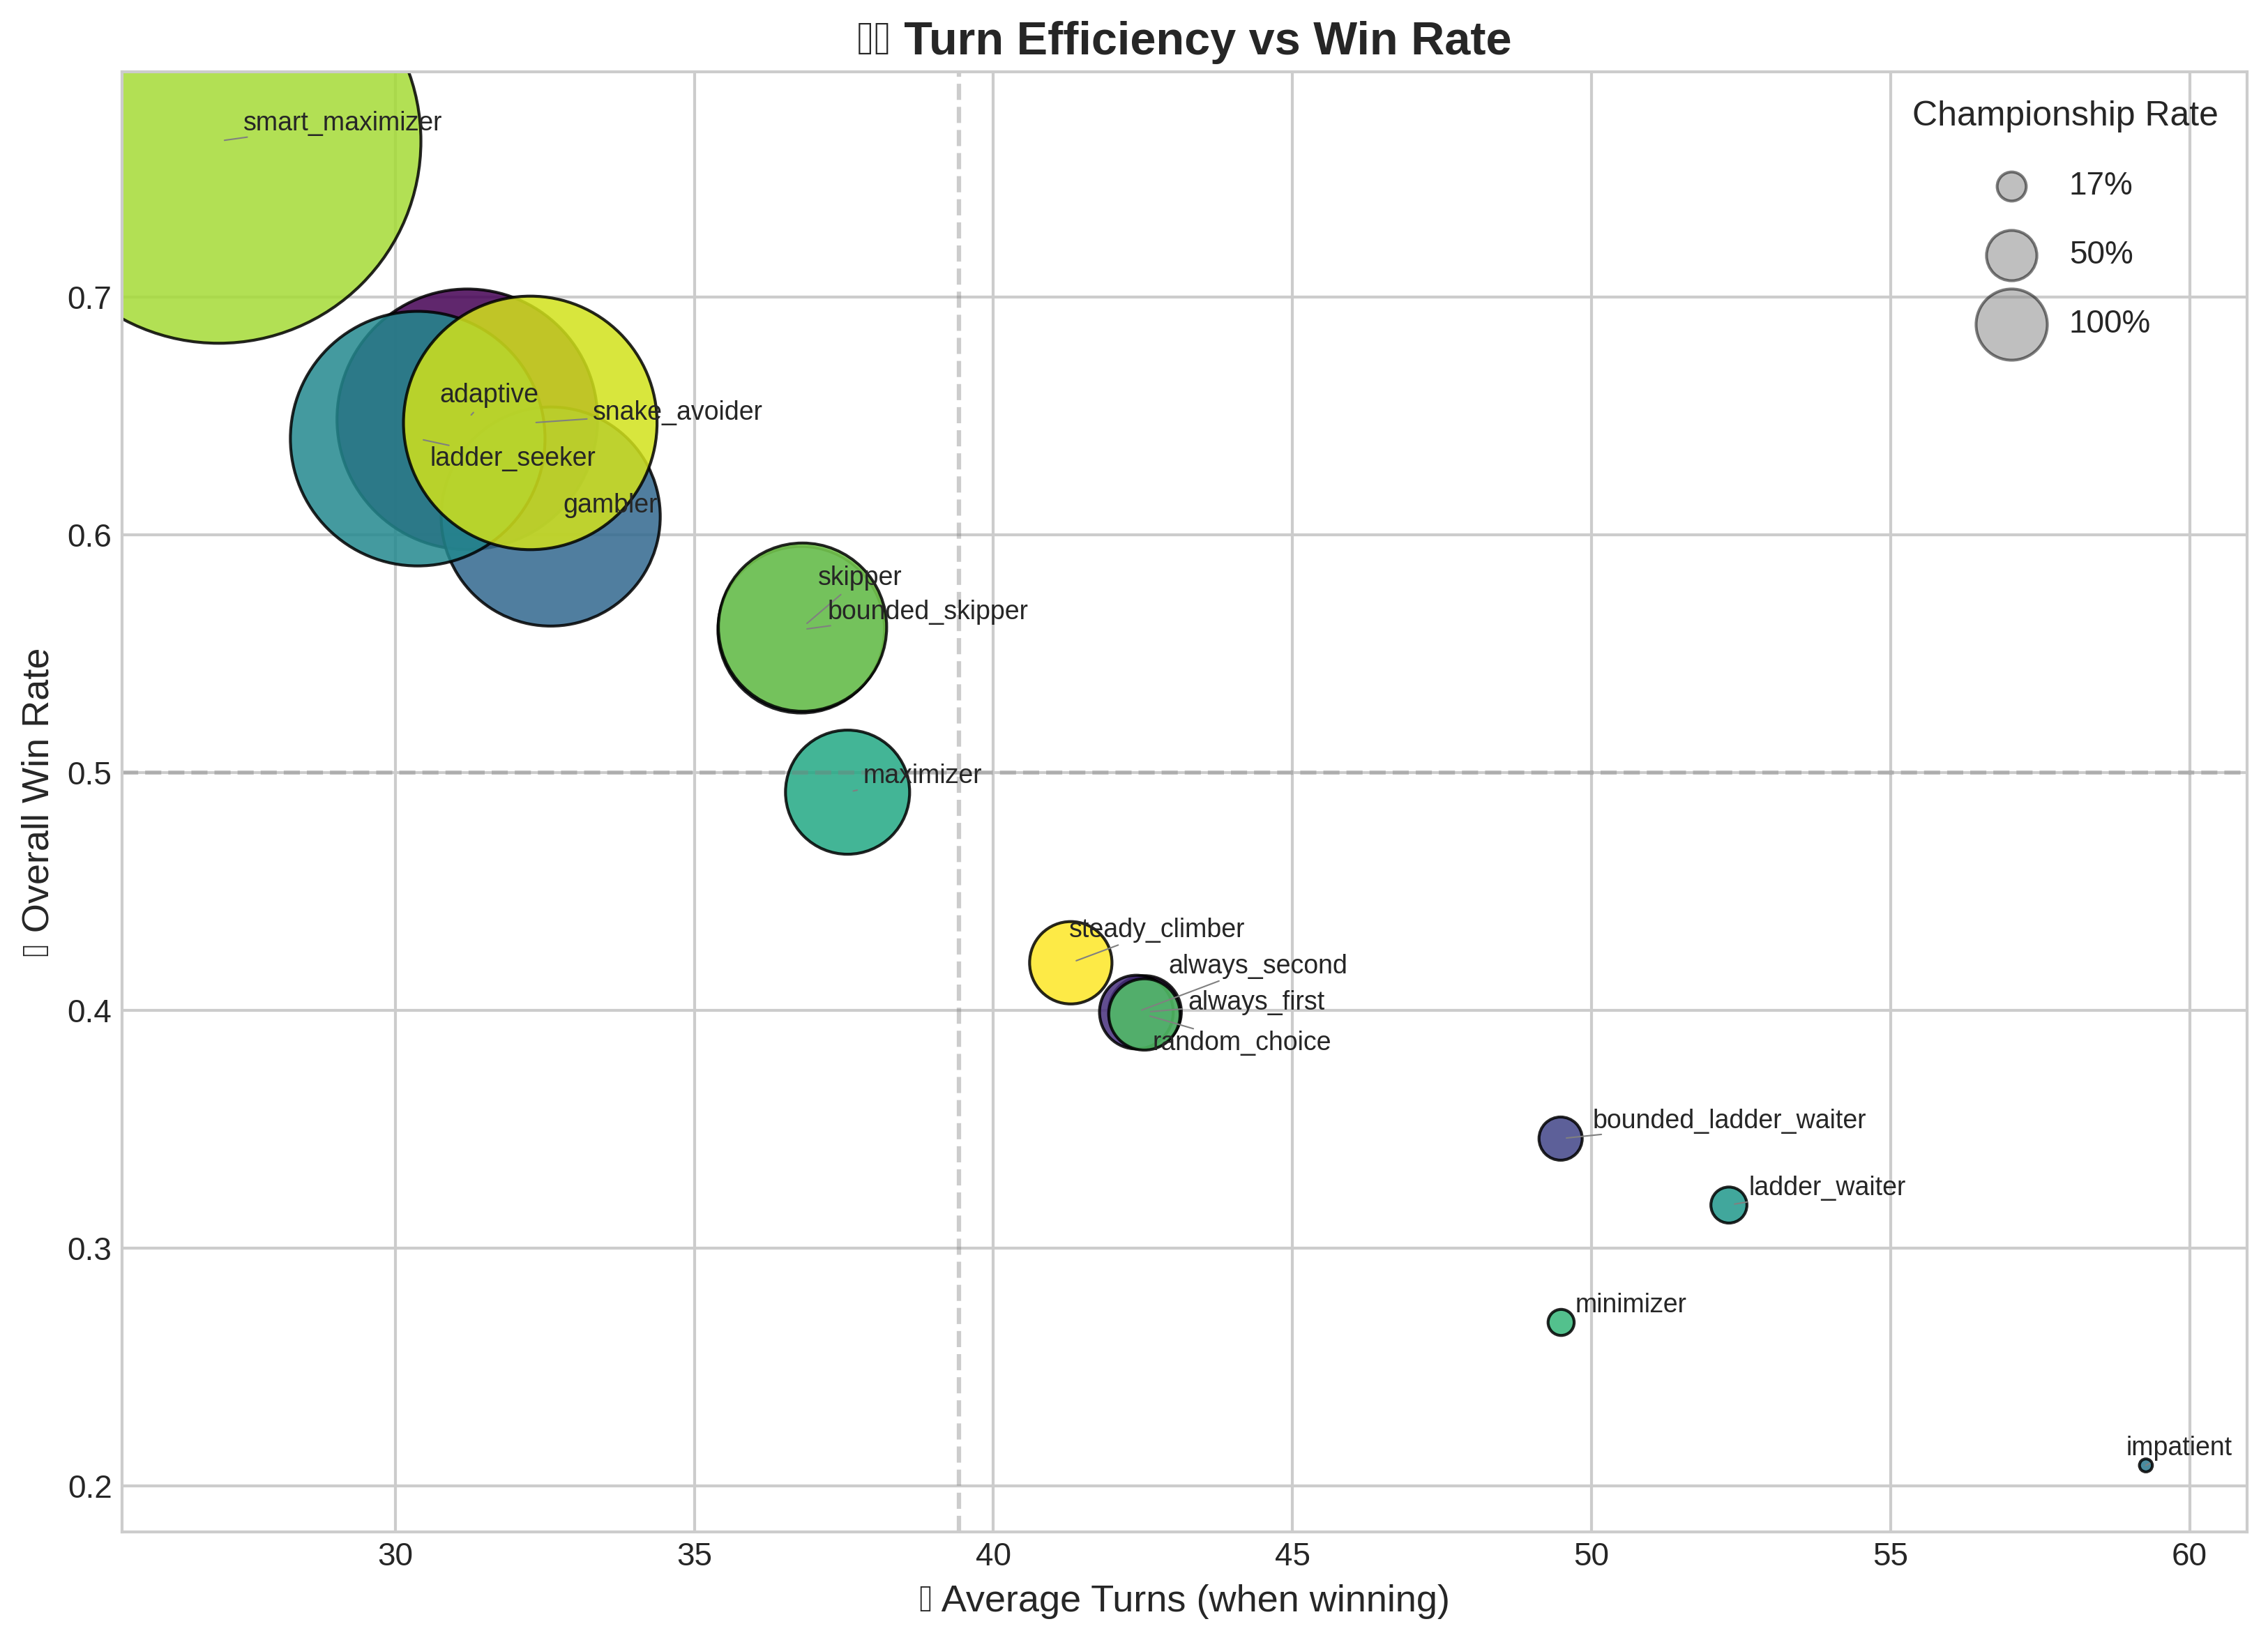

In [32]:
# Save metrics to CSV
metrics_export = metrics.copy()
metrics_export.to_csv("turn_efficiency_vs_winrate.csv")

# Plot
fig, ax = plt.subplots(figsize=(11, 8))
scatter = ax.scatter(
    metrics['Avg Turns'], 
    metrics['Win Rate'],
    s=metrics['Final Rate'] * 600,  # Bubble size
    c=range(len(agents)),
    cmap="viridis",
    alpha=0.85,
    edgecolors='black'
)

# Axes and title
ax.set_title("⚔️ Turn Efficiency vs Win Rate", fontsize=16, fontweight='bold')
ax.set_xlabel("📏 Average Turns (when winning)", fontsize=13)
ax.set_ylabel("🏆 Overall Win Rate", fontsize=13)

# Reference lines
ax.axvline(metrics['Avg Turns'].median(), color='gray', linestyle='--', alpha=0.4)
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.4)

# Smart text placement using adjustText
texts = []
for i, agent in enumerate(agents):
    x = metrics['Avg Turns'][i]
    y = metrics['Win Rate'][i]
    texts.append(ax.text(x, y, agent, fontsize=9))

adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Bubble size legend
sizes = [100, 300, 600]
labels = [f"{s/600:.0%}" for s in sizes]
handles = [plt.scatter([], [], s=s, color='gray', edgecolors='black', alpha=0.5) for s in sizes]
ax.legend(handles, labels, title="Championship Rate", labelspacing=1.2, loc='upper right')

plt.tight_layout()
plt.show()

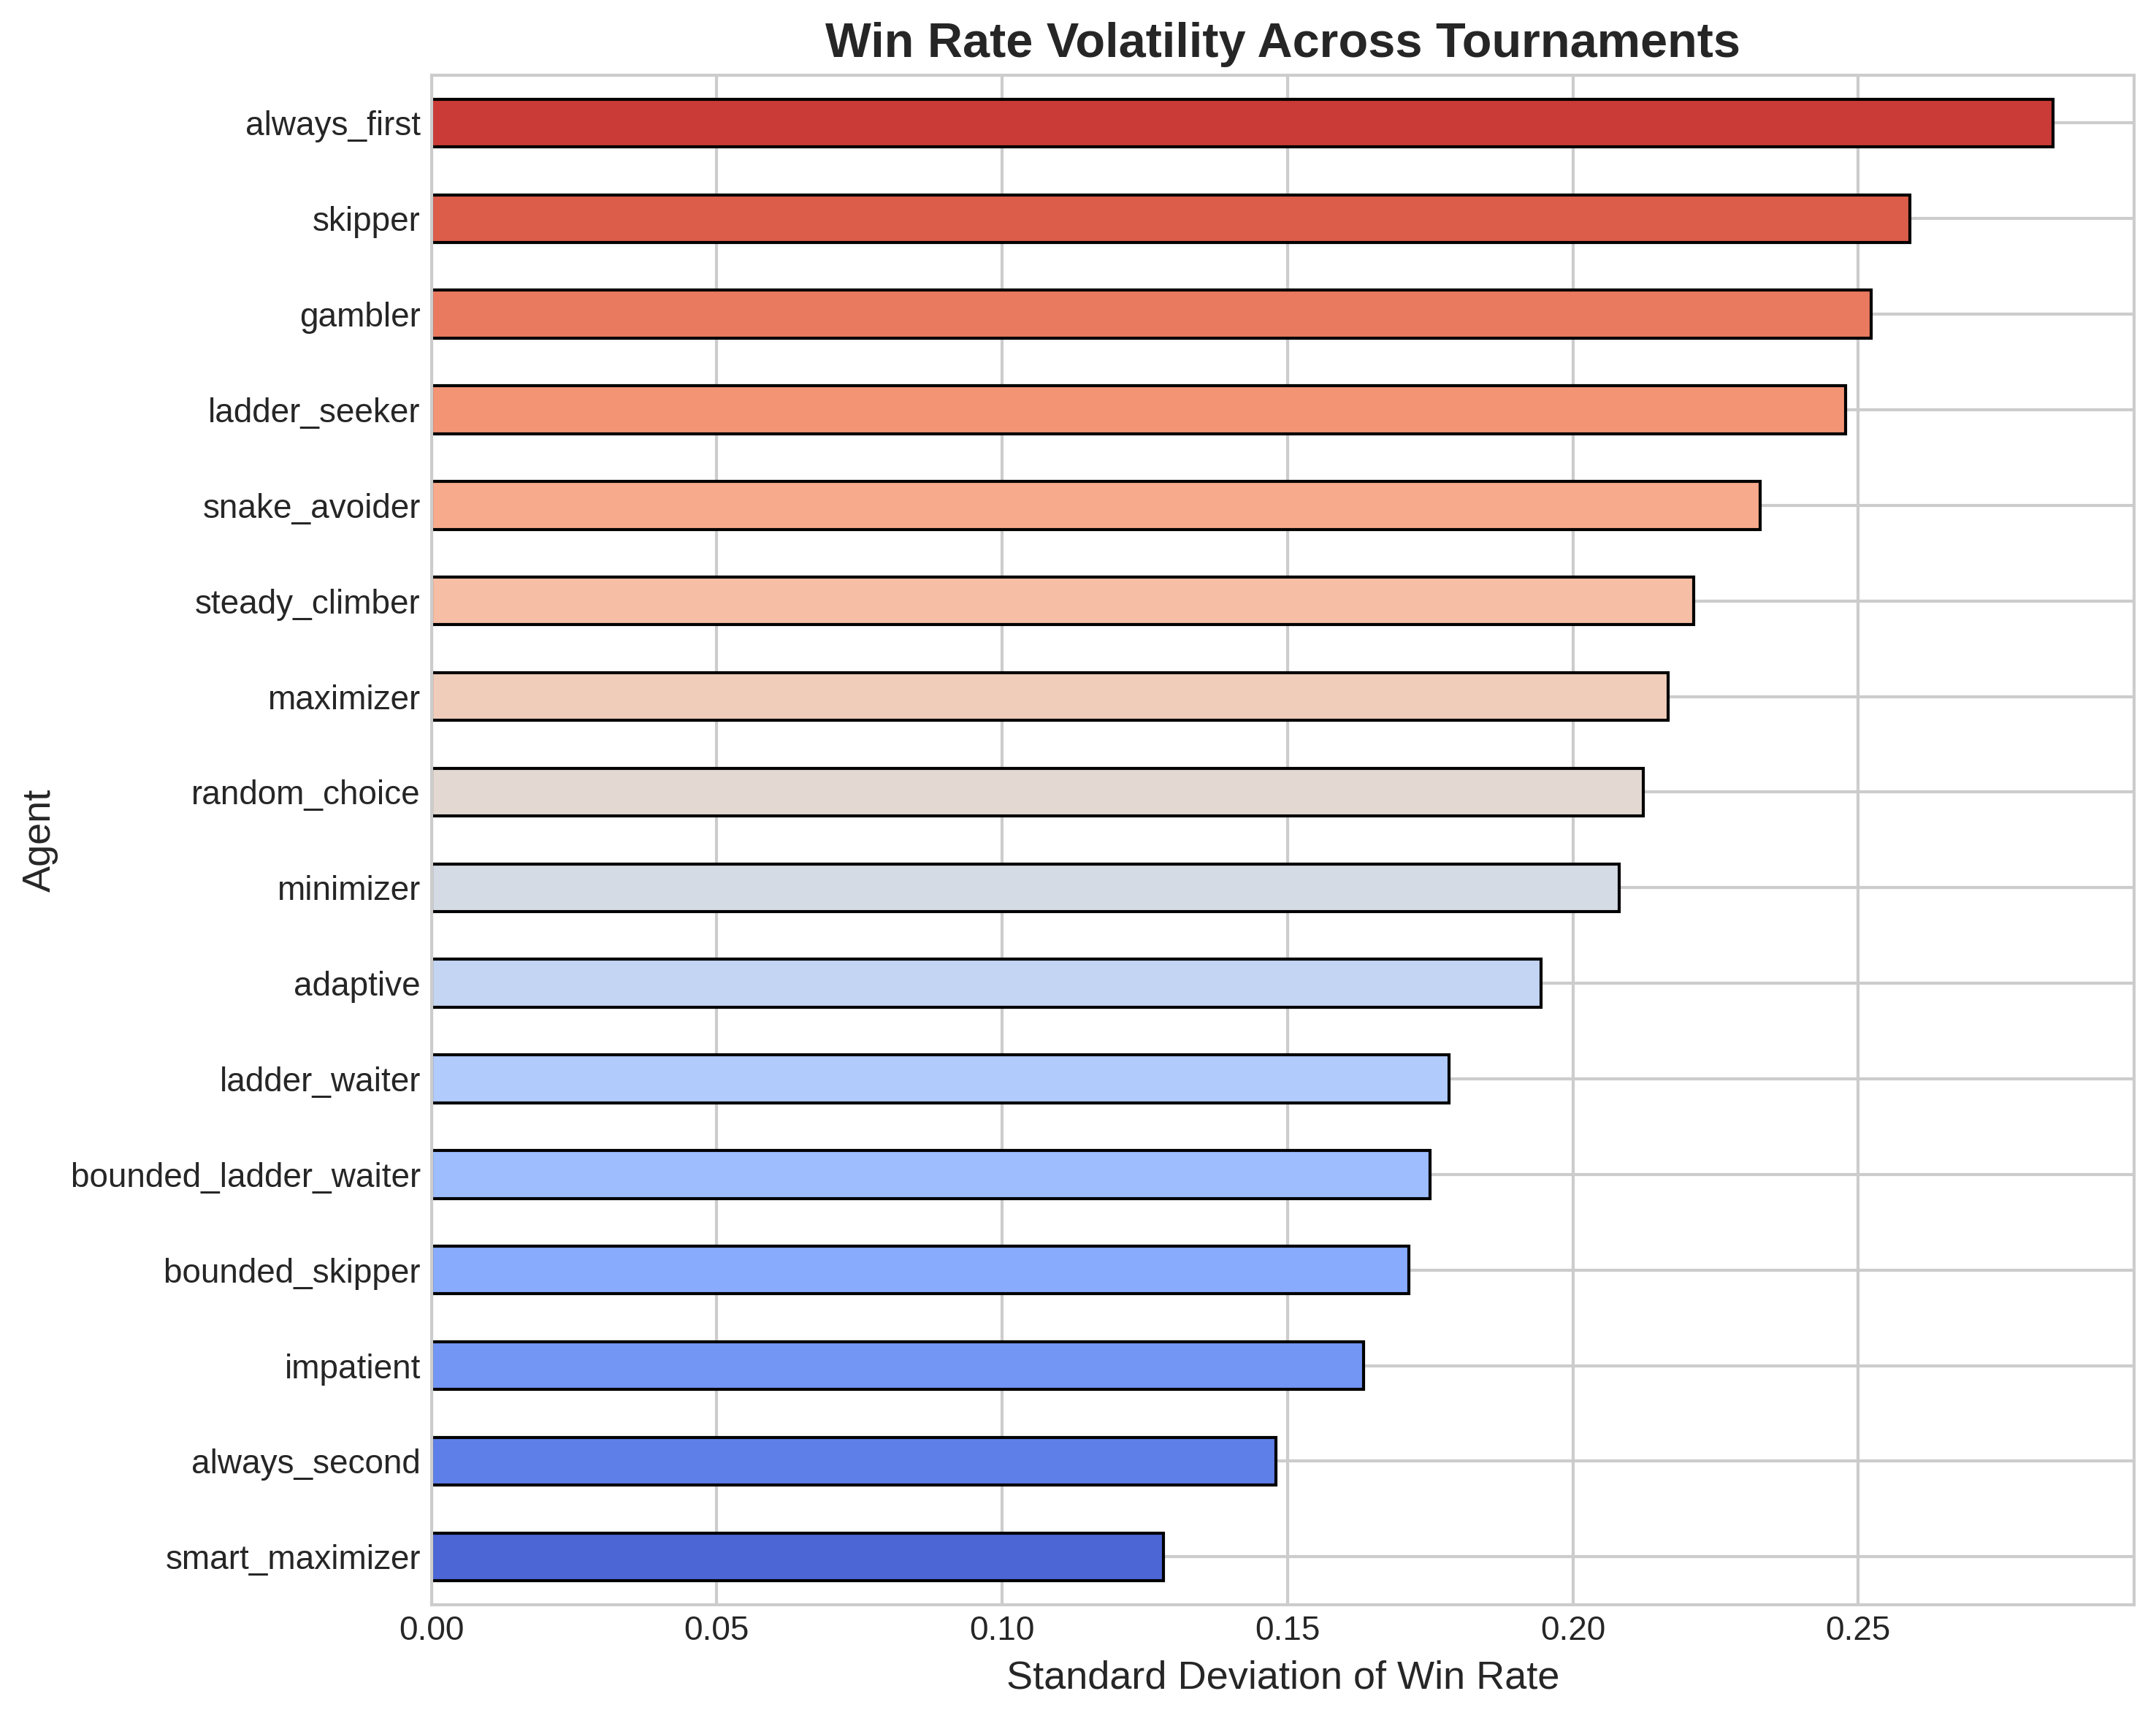

In [34]:
# Compute win rate volatility
win_std = []
for agent in agents:
    agent_wins = []
    for tournament in range(1, 100001, 10000):  # Sample every 10Kth tournament
        tourn_matches = df[(df['Tournament'] == tournament) & 
                          ((df['Player 1'] == agent) | (df['Player 2'] == agent))]
        wins = (tourn_matches['Winner'] == agent).sum()
        total = len(tourn_matches)
        if total > 0:
            agent_wins.append(wins / total)
    win_std.append(np.std(agent_wins) if agent_wins else 0)

# Build and sort volatility Series
volatility = pd.Series(win_std, index=agents).sort_values()

# ✅ Export to CSV
volatility.to_frame(name='Win_Rate_Volatility').to_csv("win_rate_volatility.csv")

# 📊 Horizontal Bar Chart with Semantic Color
fig, ax = plt.subplots(figsize=(10, 8))
colors = sns.color_palette("coolwarm", len(volatility))
volatility.plot(kind='barh', color=colors, ax=ax, edgecolor='black')

# Title and labels
ax.set_title("Win Rate Volatility Across Tournaments", fontsize=16, fontweight='bold')
ax.set_xlabel("Standard Deviation of Win Rate", fontsize=13)
ax.set_ylabel("Agent", fontsize=13)

plt.tight_layout()
plt.show()

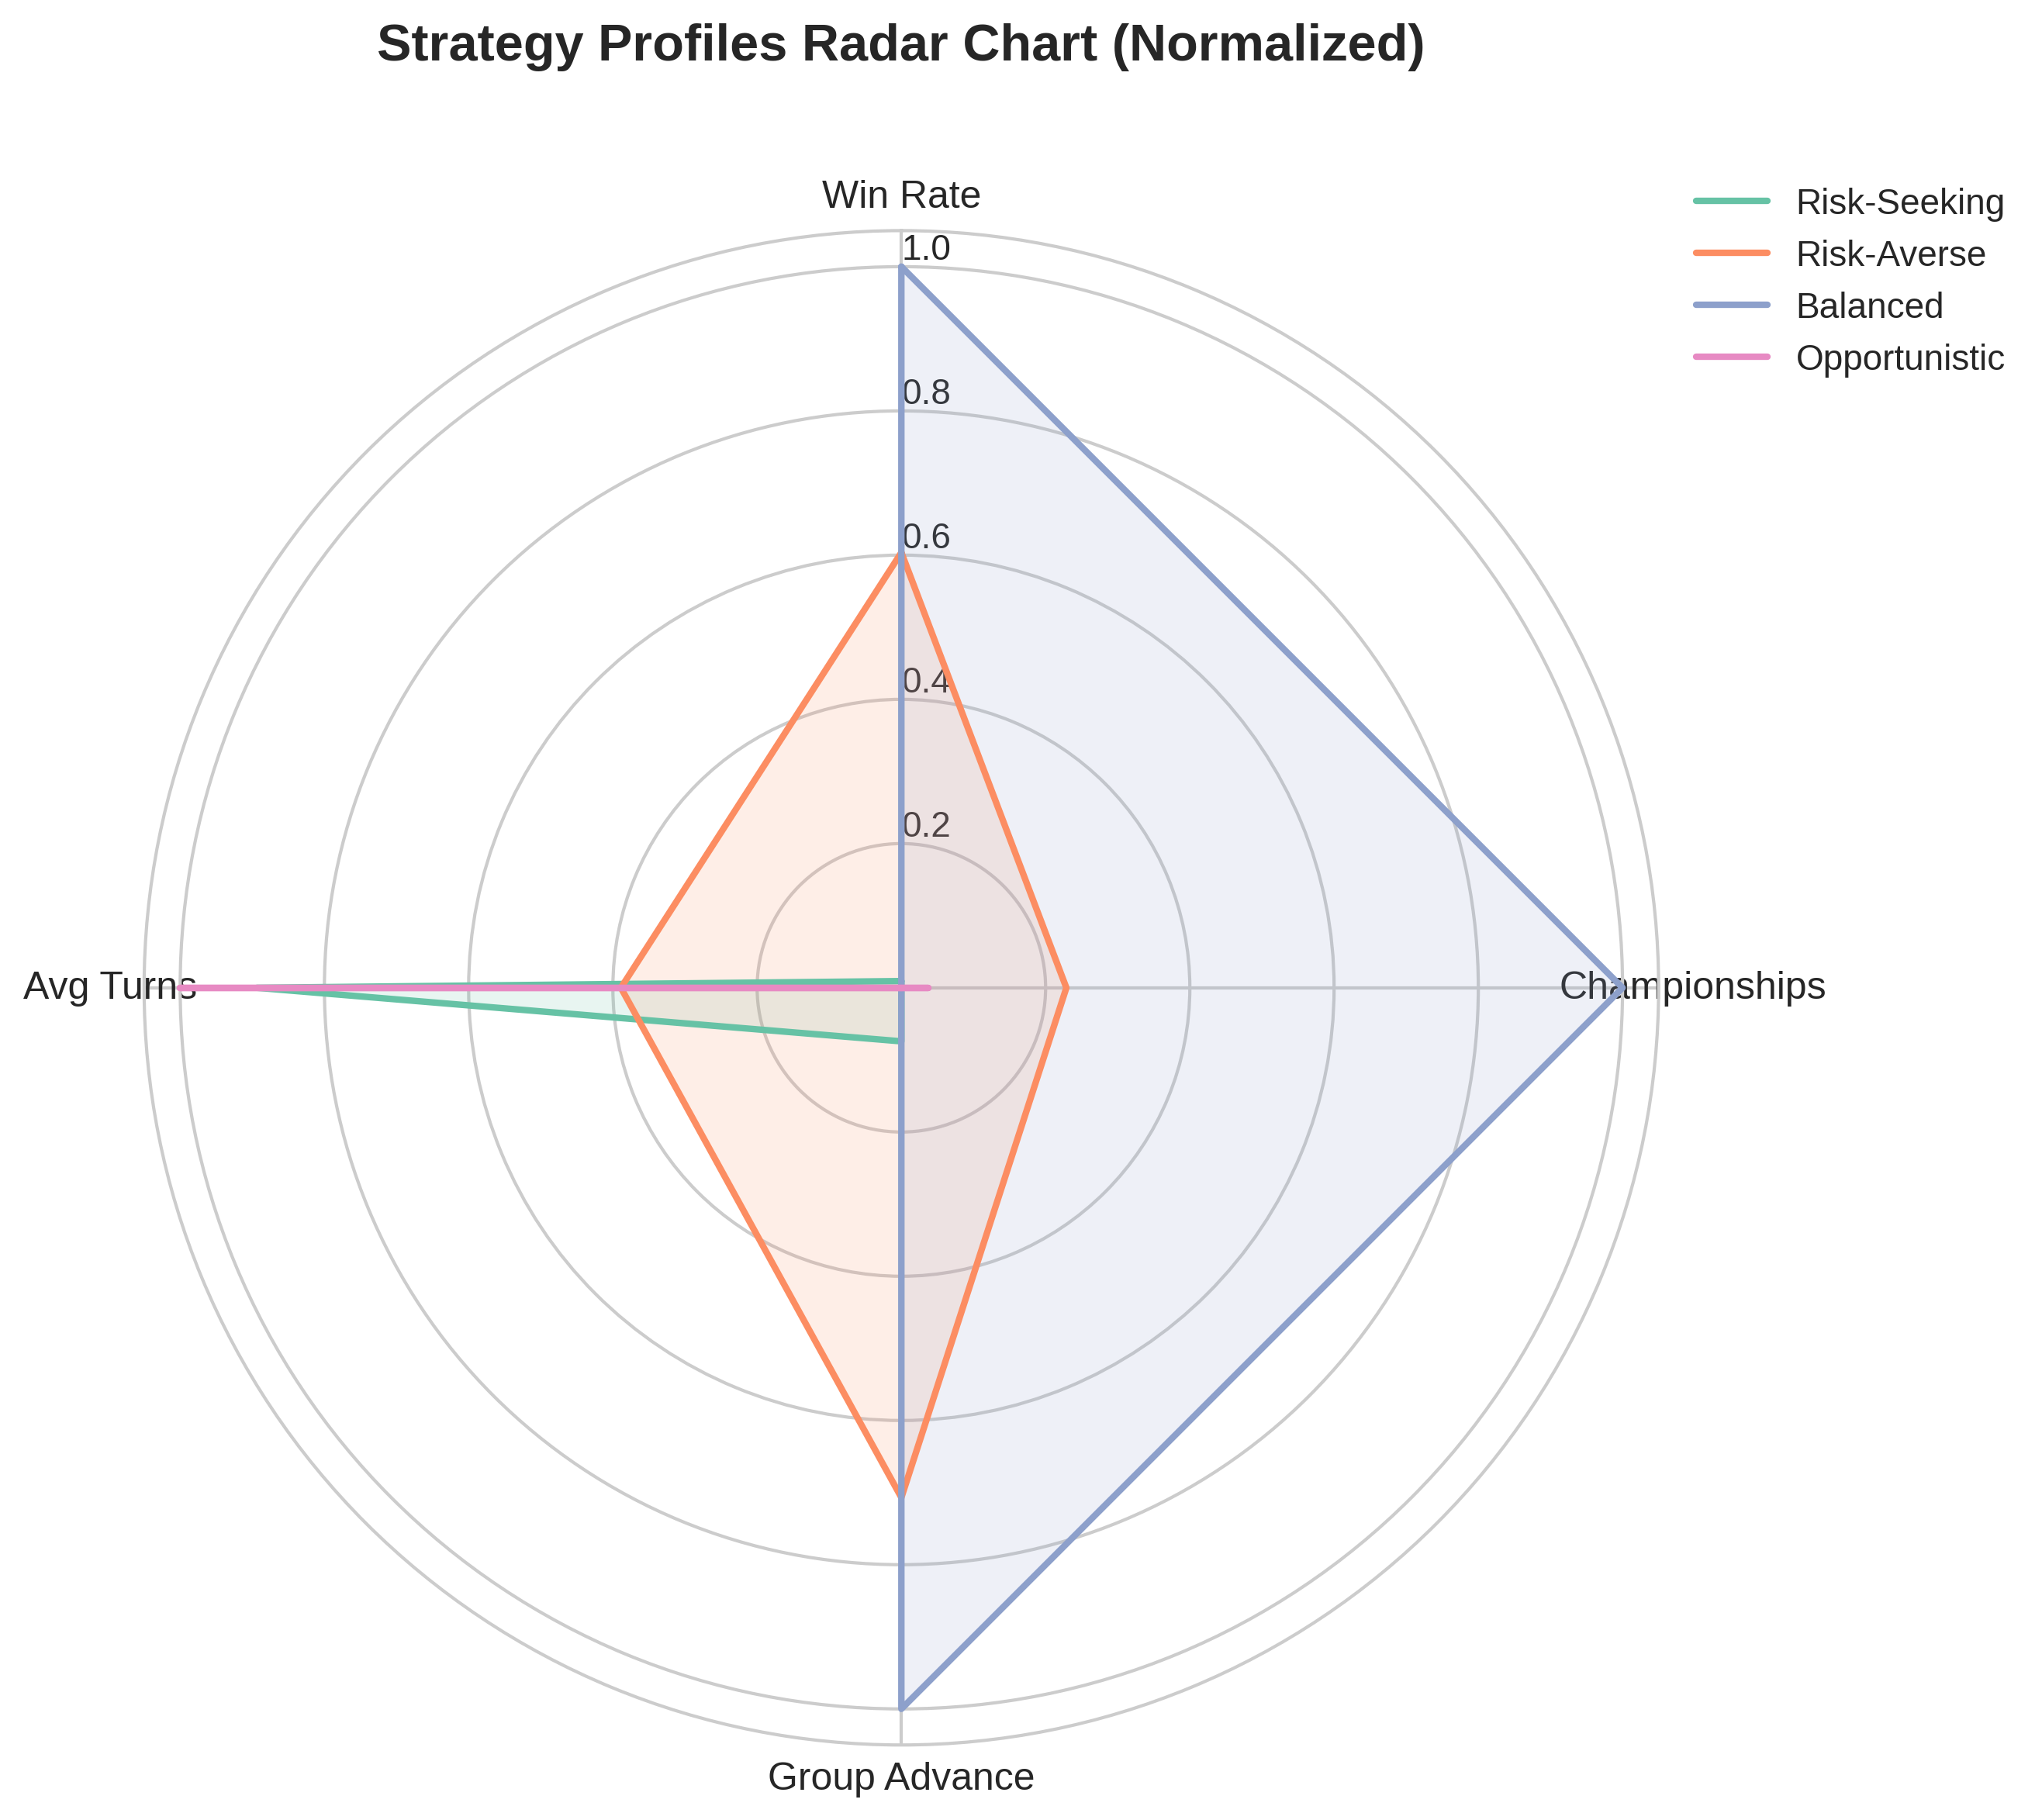

In [36]:
# Prepare DataFrame
profiles = {
    'Risk-Seeking': ['gambler', 'impatient', 'maximizer'],
    'Risk-Averse': ['minimizer', 'snake_avoider', 'skipper', 'bounded_skipper'],
    'Balanced': ['smart_maximizer', 'adaptive', 'random_choice', 'steady_climber'],
    'Opportunistic': ['ladder_seeker', 'ladder_waiter', 'bounded_ladder_waiter']
}

profile_metrics = []
for name, group in profiles.items():
    profile_metrics.append({
        'Profile': name,
        'Win Rate': metrics.loc[group, 'Win Rate'].mean(),
        'Championships': metrics.loc[group, 'Final Rate'].sum() / len(group),
        'Group Advance': metrics.loc[group, 'Group Advance'].mean(),
        'Avg Turns': metrics.loc[group, 'Avg Turns'].mean()
    })

# DataFrame
profile_df = pd.DataFrame(profile_metrics).set_index('Profile')

# ✅ Export to CSV
profile_df.to_csv("strategy_profile_comparison.csv")

# Normalize data for better radar comparison (optional)
normalized_df = profile_df.copy()
for col in normalized_df.columns:
    max_val = normalized_df[col].max()
    min_val = normalized_df[col].min()
    normalized_df[col] = (normalized_df[col] - min_val) / (max_val - min_val)

# Radar chart setup
categories = list(normalized_df.columns)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)
plt.xticks(angles[:-1], categories, fontsize=12)
ax.set_title("Strategy Profiles Radar Chart (Normalized)", fontsize=16, fontweight='bold', y=1.1)

# Color palette
colors = sns.color_palette("Set2", len(normalized_df))

# Draw each profile
for i, (profile, row) in enumerate(normalized_df.iterrows()):
    values = row.tolist() + row.tolist()[:1]
    ax.plot(angles, values, label=profile, color=colors[i], linewidth=2)
    ax.fill(angles, values, color=colors[i], alpha=0.15)

ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.05))
plt.tight_layout()
plt.show()